In [1]:
import os
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive')

# -------------------------------
# 1. Read datasets for years 2020–2024
# -------------------------------
base_dir = "/content/drive/My Drive/datasets"
years = range(2015, 2025)
quarters = ["Q1", "Q2", "Q3", "Q4"]

all_drug_dfs = []
all_demo_dfs = []
all_reac_dfs = []
all_indi_dfs = []

def extract_year_quarter(folder_name):
    match = re.search(r'faers_(\d{4})(Q\d)', folder_name)
    if match:
        return int(match.group(1)), match.group(2)
    return None, None

# Encoding recognition function
def robust_read_faers_txt(file_path, sep="$"):
    for enc in ["utf-8", "ISO-8859-1", "cp1252"]:
        try:
            df = pd.read_csv(file_path, sep=sep, encoding=enc, low_memory=False)
            return df
        except Exception:
            continue
    print(f"⚠ Failed to load file with common encodings: {file_path}")
    return None

for year in years:
    for quarter in quarters:
        folder_name = f"faers_{year}{quarter}"
        folder_path = os.path.join(base_dir, folder_name)
        if not os.path.isdir(folder_path):
            print(f"❌ Folder not found: {folder_path}")
            continue

        y, q_label = extract_year_quarter(folder_name)
        year_str = str(year)[2:]

        file_types = {
            "DRUG": all_drug_dfs,
            "DEMO": all_demo_dfs,
            "REAC": all_reac_dfs,
            "INDI": all_indi_dfs
        }

        for file_prefix, collection in file_types.items():
            file_path = os.path.join(folder_path, f"{file_prefix}{year_str}{quarter}.txt")
            if os.path.isfile(file_path):
                df = robust_read_faers_txt(file_path)
                if df is not None:
                    df["year"] = y
                    df["quarter"] = q_label
                    collection.append(df)
                    print(f"✅ Loaded {file_path} with shape {df.shape}")
                else:
                    print(f"⚠ Failed to read: {file_path}")
            else:
                print(f"❌ File not found: {file_path}")

# Concatenate data for each type
drug_df = pd.concat(all_drug_dfs, ignore_index=True) if all_drug_dfs else pd.DataFrame()
demo_df = pd.concat(all_demo_dfs, ignore_index=True) if all_demo_dfs else pd.DataFrame()
reac_df = pd.concat(all_reac_dfs, ignore_index=True) if all_reac_dfs else pd.DataFrame()
indi_df = pd.concat(all_indi_dfs, ignore_index=True) if all_indi_dfs else pd.DataFrame()

print("✅ Combined drug_df shape:", drug_df.shape)
print("✅ Combined demo_df shape:", demo_df.shape)
print("✅ Combined reac_df shape:", reac_df.shape)
print("✅ Combined indi_df shape:", indi_df.shape)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q1/DRUG15Q1.txt with shape (1082833, 22)
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q1/DEMO15Q1.txt with shape (317071, 27)
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q1/REAC15Q1.txt with shape (872848, 6)
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q1/INDI15Q1.txt with shape (748742, 6)
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q2/DRUG15Q2.txt with shape (967120, 22)
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q2/DEMO15Q2.txt with shape (289270, 27)
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q2/REAC15Q2.txt with shape (845134, 6)
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q2/INDI15Q2.txt with shape (659529, 6)
✅ Loaded /content/drive/My Drive/datasets/faers_2015Q3/DRUG15Q3.txt with shape (1294625, 22)
✅ Loaded /content/drive/My Drive/datasets/fae

In [2]:
print(drug_df.head())
print(demo_df.head())
print(reac_df.head())
print(indi_df.head())

   primaryid    caseid  drug_seq role_cod    drugname  \
0  100036412  10003641         1       PS    DEPAKOTE   
1  100036412  10003641         2        C      INVEGA   
2  100036412  10003641         3        C   METFORMIN   
3  100036412  10003641         4        C  BISOPROLOL   
4  100036412  10003641         5        C    COGENTIN   

                   prod_ai  val_vbm route                   dose_vbm  \
0        DIVALPROEX SODIUM        1  ORAL  ONE IN AM AND  TWO IN  PM   
1             PALIPERIDONE        1   NaN                        NaN   
2  METFORMIN HYDROCHLORIDE        1   NaN                        NaN   
3               BISOPROLOL        1   NaN                        NaN   
4     BENZTROPINE MESYLATE        1   NaN                        NaN   

   cum_dose_chr  ... rechal   lot_num exp_dt nda_num dose_amt dose_unit  \
0           NaN  ...      D   UNKNOWN    NaN  018723      NaN       NaN   
1           NaN  ...      D       NaN    NaN     NaN      NaN       NaN   

In [3]:
# 2. Filter for Prednisolone records and classify them into 5 categories
drug_df['drugname_clean'] = drug_df['drugname'].str.upper().fillna("")
prednisolone_drugs = drug_df[drug_df['drugname_clean'].str.contains("PREDNISOLONE", na=False)]
prednisolone_df = prednisolone_drugs.copy()

def classify_pred_methyl_5cat(drugname):
    """
    Classify drug names into 5 categories:
    1) PREDNISOLONE (base)
    2) PREDNISOLONE_DERIVATIVE
    3) METHYLPREDNISOLONE (base)
    4) METHYLPREDNISOLONE_DERIVATIVE
    5) COMBINATION (if multiple active ingredients are present)
    """
    name = drugname.upper()
    if re.search(r'[\\/;]', name):
        return "COMBINATION"
    if "METHYLPREDNISOLONE" in name:
        if any(x in name for x in ["ACETATE", "PHOSPHATE", "SUCCINATE", "ACEPONATE", "HEMISUCCINATE"]):
            return "METHYLPREDNISOLONE_DERIVATIVE"
        else:
            return "METHYLPREDNISOLONE"
    elif "PREDNISOLONE" in name:
        if any(x in name for x in ["ACETATE", "PHOSPHATE", "STEAGLATE", "VALERATE", "SUCCINATE", "METASULFO", "METAZOATE"]):
            return "PREDNISOLONE_DERIVATIVE"
        else:
            return "PREDNISOLONE"
    else:
        return np.nan

prednisolone_df['major_class_5cat'] = prednisolone_df['drugname_clean'].apply(classify_pred_methyl_5cat)
print("Classification counts (5 categories):")
print(prednisolone_df['major_class_5cat'].value_counts(dropna=False))



Classification counts (5 categories):
major_class_5cat
PREDNISOLONE                     228368
METHYLPREDNISOLONE               143985
METHYLPREDNISOLONE_DERIVATIVE     32286
PREDNISOLONE_DERIVATIVE           14482
COMBINATION                        1829
Name: count, dtype: int64


In [4]:
# -------------------------------
# 3. Merge with DEMO, REAC, and INDI datasets based on caseid
# -------------------------------
caseids = prednisolone_df['caseid'].unique()

demo_keep = ['primaryid', 'caseid', 'year', 'quarter', 'age', 'sex']
reac_keep = ['primaryid', 'caseid', 'year', 'quarter', 'pt']
indi_keep = ['primaryid', 'caseid', 'year', 'quarter', 'indi_pt']
pred_keep = ['primaryid', 'caseid', 'year', 'quarter', 'drug_seq', 'role_cod', 'drugname', 'drugname_clean', 'major_class_5cat', 'dechal', 'rechal']


demo_sub = demo_df[demo_df['caseid'].isin(caseids)][demo_keep]
reac_sub = reac_df[reac_df['caseid'].isin(caseids)][reac_keep]
indi_sub = indi_df[indi_df['caseid'].isin(caseids)][indi_keep]
pred_sub = prednisolone_df[pred_keep]

merged_demo_drug = pd.merge(demo_sub, pred_sub, on=['primaryid','caseid','year','quarter'], how='left')
merged_drug_reac = pd.merge(merged_demo_drug, reac_sub, on=['primaryid','caseid','year','quarter'], how='left')
final_merged = pd.merge(merged_drug_reac, indi_sub, on=['primaryid','caseid','year','quarter'], how='left')

print("Final merged DataFrame shape:", final_merged.shape)
print(final_merged.head(10))



Final merged DataFrame shape: (82721141, 15)
   primaryid    caseid  year quarter   age sex  drug_seq role_cod  \
0  100120312  10012031  2015      Q1  69.0   F       5.0        C   
1  100120312  10012031  2015      Q1  69.0   F       5.0        C   
2  100120312  10012031  2015      Q1  69.0   F       5.0        C   
3  100120312  10012031  2015      Q1  69.0   F       5.0        C   
4  100120312  10012031  2015      Q1  69.0   F       5.0        C   
5  100120312  10012031  2015      Q1  69.0   F       5.0        C   
6  100120312  10012031  2015      Q1  69.0   F       5.0        C   
7  100120312  10012031  2015      Q1  69.0   F       5.0        C   
8  100120312  10012031  2015      Q1  69.0   F       5.0        C   
9  100120312  10012031  2015      Q1  69.0   F       5.0        C   

        drugname drugname_clean major_class_5cat dechal rechal          pt  \
0  PREDNISOLONE.  PREDNISOLONE.     PREDNISOLONE    NaN      D  Haemolysis   
1  PREDNISOLONE.  PREDNISOLONE.     PRE

In [5]:
# -------------------------------
# 4. Aggregate records: one row per (year, quarter, caseid)
# -------------------------------
def join_unique(x):
    return "; ".join(sorted(set(x.dropna())))

final_one_row = final_merged.groupby(['year','quarter','caseid'], as_index=False).agg({
    'age': 'first',
    'sex': 'first',
    'drugname_clean': 'first',
    'major_class_5cat': 'first',
    'pt': join_unique,
    'indi_pt': join_unique,
    'dechal': 'first',
    'rechal': 'first'
})

print("Aggregated DataFrame shape:", final_one_row.shape)
print(final_one_row.head(10))

# -------------------------------
# 5. Create additional variable: Age Group
# -------------------------------
bins = [0, 18, 35, 50, 65, 100]
labels = ['0-18', '18-35', '35-50', '50-65', '65+']
final_one_row['age_group'] = pd.cut(final_one_row['age'], bins=bins, labels=labels)

# -------------------------------
# 6. Explode the 'pt' column (adverse events) for detailed mapping
# -------------------------------
# Assume 'pt' is a string with adverse events separated by "; "
final_one_row['pt_list'] = final_one_row['pt'].str.split("; ")
exploded_df = final_one_row.explode('pt_list')



Aggregated DataFrame shape: (289683, 11)
   year quarter   caseid   age sex  \
0  2015      Q1  3759885  56.0   M   
1  2015      Q1  6154259  95.0   F   
2  2015      Q1  6238012  62.0   M   
3  2015      Q1  6736578  44.0   F   
4  2015      Q1  6762250  69.0   F   
5  2015      Q1  7131598  61.0   M   
6  2015      Q1  7166815  53.0   M   
7  2015      Q1  7196723  29.0   F   
8  2015      Q1  7277761  61.0   F   
9  2015      Q1  7336329  72.0   F   

                                      drugname_clean  \
0  METHYLPREDNISOLONE SODIUM SUCCINATE (METHYLPRE...   
1                                      PREDNISOLONE.   
2                                METHYLPREDNISOLONE.   
3                                      PREDNISOLONE.   
4                                      PREDNISOLONE.   
5                                      PREDNISOLONE.   
6                                               None   
7                                METHYLPREDNISOLONE.   
8                                   

<ipython-input-6-17927dfb12fb>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='year', y='report_count', data=yearly_counts, palette="Blues_d")


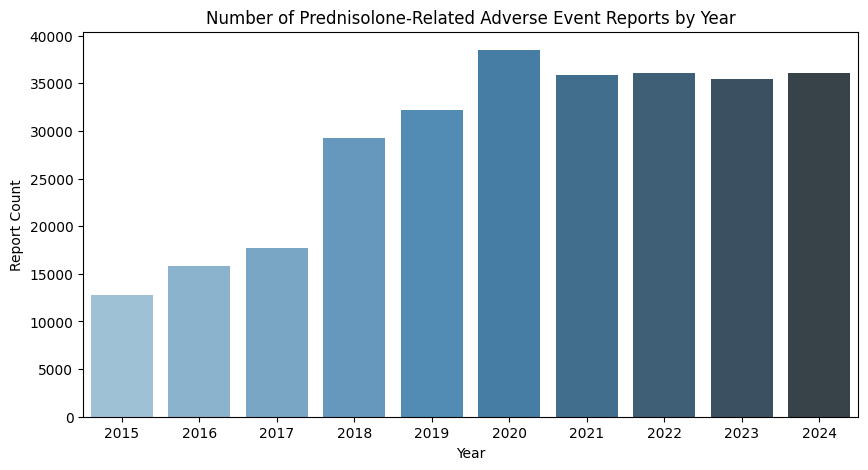

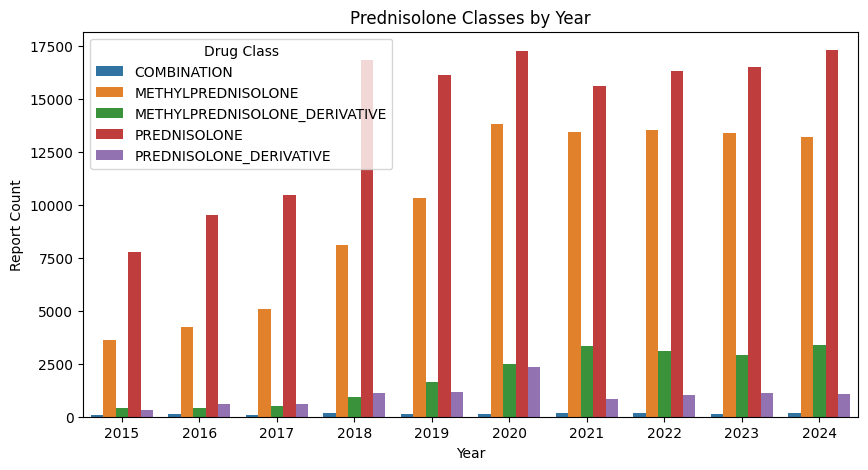

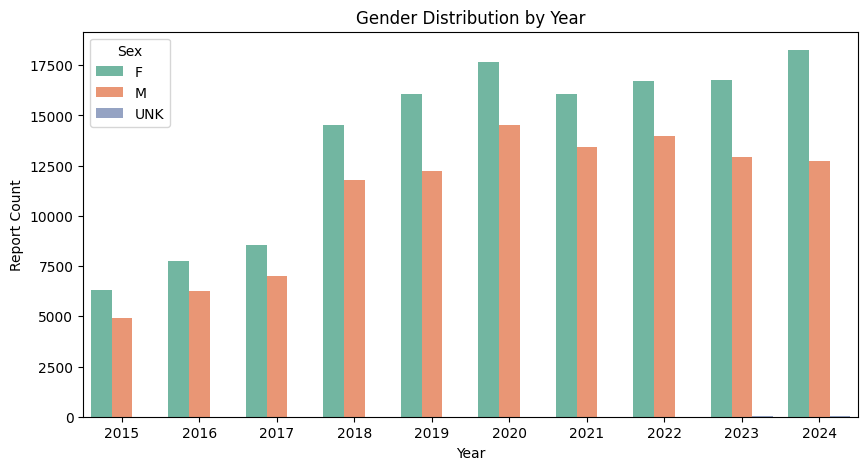

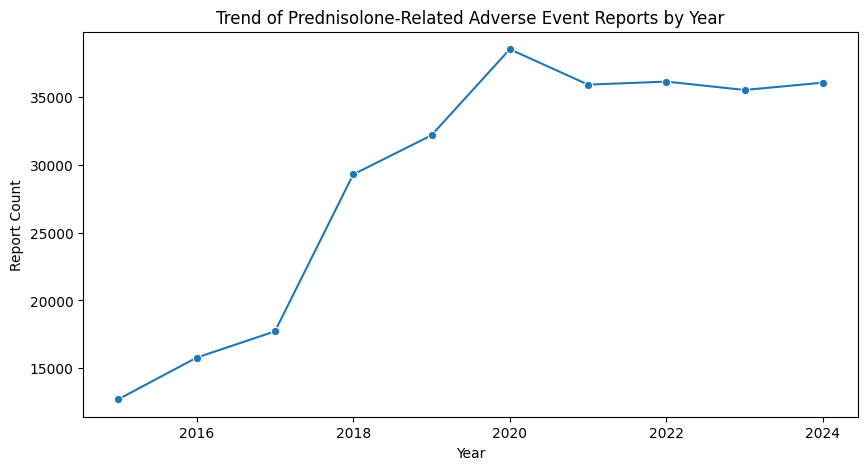

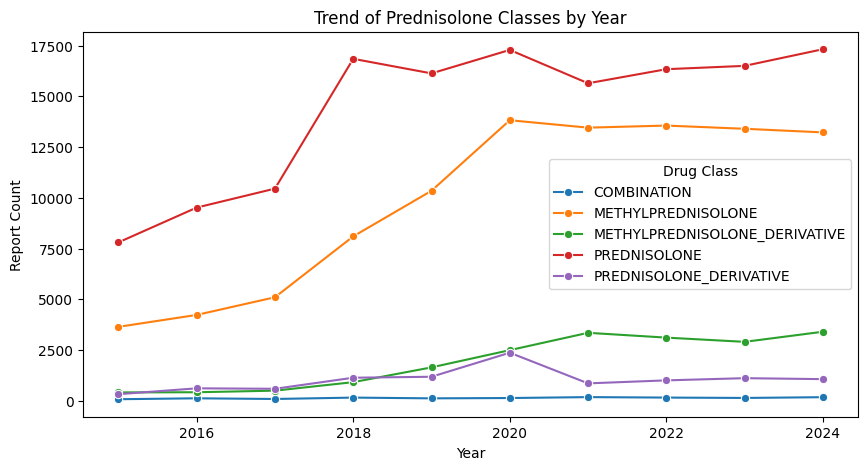

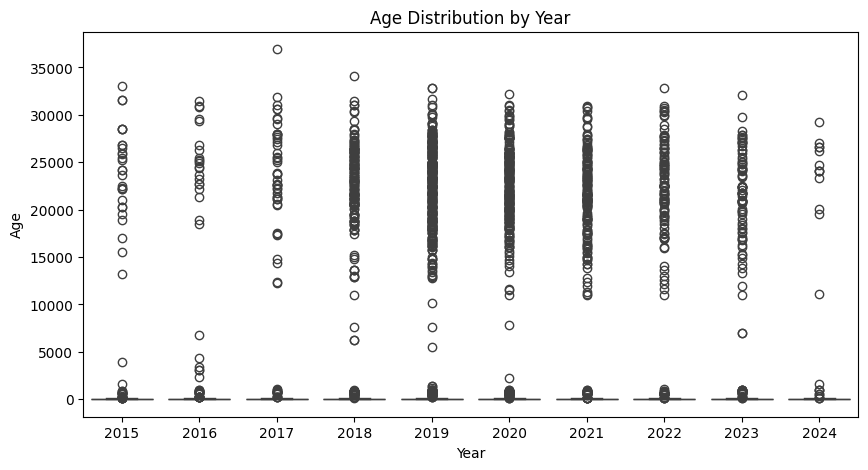

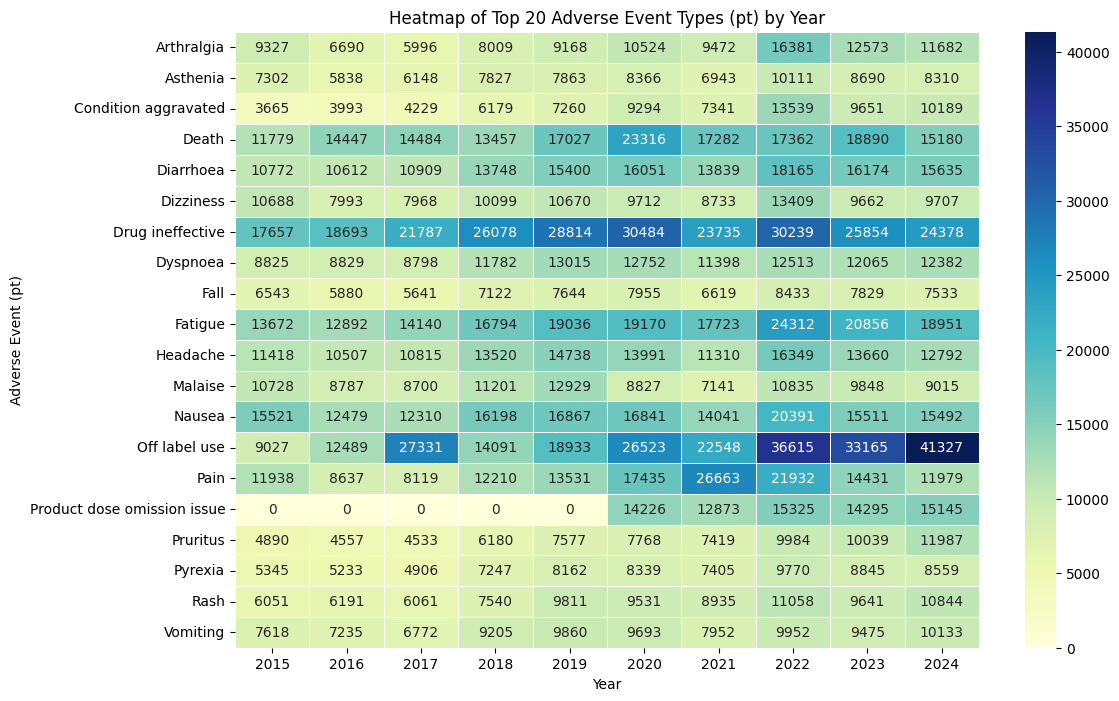

<ipython-input-6-17927dfb12fb>:73: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  class_age_pivot = exploded_df.groupby(['major_class_5cat', 'age_group']).size().reset_index(name='count')


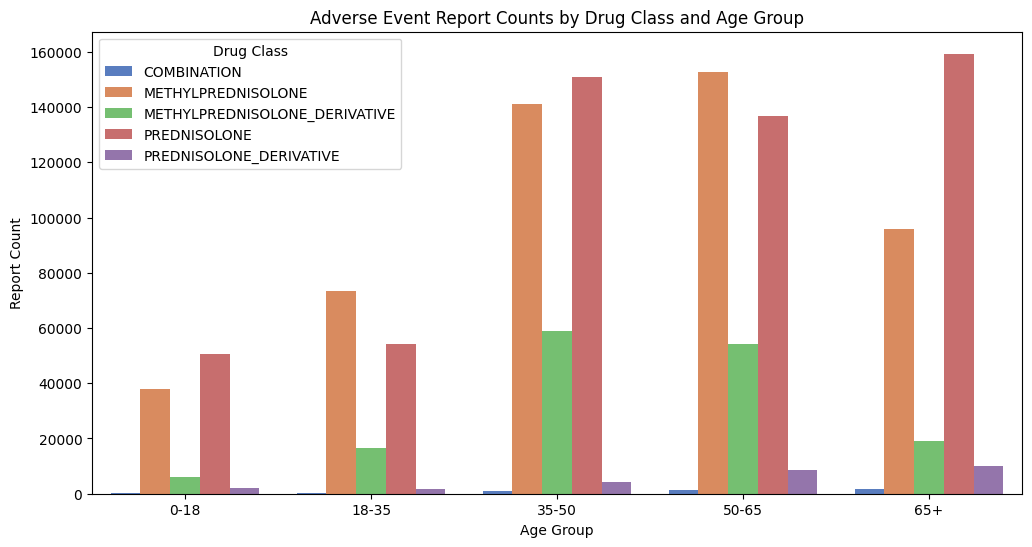

Visualizations for data (2015–2024) have been generated.


In [6]:
# -------------------------------
# 7. Visualization
# -------------------------------

# (a) Bar Plot: Total number of adverse event reports by year
yearly_counts = final_one_row.groupby('year').size().reset_index(name='report_count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='report_count', data=yearly_counts, palette="Blues_d")
plt.title("Number of Prednisolone-Related Adverse Event Reports by Year")
plt.xlabel("Year")
plt.ylabel("Report Count")
plt.show()

# (b) Bar Plot: Distribution of the 5 drug classes across years
class_year_counts = final_one_row.groupby(['year', 'major_class_5cat']).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='major_class_5cat', data=class_year_counts)
plt.title("Prednisolone Classes by Year")
plt.xlabel("Year")
plt.ylabel("Report Count")
plt.legend(title="Drug Class")
plt.show()

# (c) Bar Plot: Gender distribution by year
year_sex_counts = final_one_row.groupby(['year', 'sex']).size().reset_index(name='count')
plt.figure(figsize=(10, 5))
sns.barplot(x='year', y='count', hue='sex', data=year_sex_counts, palette="Set2")
plt.title("Gender Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Report Count")
plt.legend(title="Sex")
plt.show()

# (d) Line Chart: Trend of total adverse event reports by year
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='report_count', data=yearly_counts, marker="o", sort=True)
plt.title("Trend of Prednisolone-Related Adverse Event Reports by Year")
plt.xlabel("Year")
plt.ylabel("Report Count")
plt.show()

# (e) Line Chart: Trend of each drug class across years
plt.figure(figsize=(10, 5))
sns.lineplot(x='year', y='count', hue='major_class_5cat', data=class_year_counts, marker="o")
plt.title("Trend of Prednisolone Classes by Year")
plt.xlabel("Year")
plt.ylabel("Report Count")
plt.legend(title="Drug Class")
plt.show()

# (f) Boxplot: Age distribution by year
plt.figure(figsize=(10, 5))
sns.boxplot(x='year', y='age', data=final_one_row)
plt.title("Age Distribution by Year")
plt.xlabel("Year")
plt.ylabel("Age")
plt.show()

# (g) Heatmap: Frequency of top 20 adverse event types (pt) by year
reac_clean = reac_df[(reac_df['year'].isin(years)) & (reac_df['quarter'] == quarter)]
top20_pt = reac_clean['pt'].value_counts().head(20).index.tolist()
filtered_reac = reac_clean[reac_clean['pt'].isin(top20_pt)]
pt_year_pivot = filtered_reac.pivot_table(index='pt', columns='year', values='primaryid', aggfunc='count', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(pt_year_pivot, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5)
plt.title("Heatmap of Top 20 Adverse Event Types (pt) by Year")
plt.xlabel("Year")
plt.ylabel("Adverse Event (pt)")
plt.show()

# (h) Additional: Bar Plot of adverse event counts by drug class and age group
# First, create a pivot table from exploded_df that aggregates counts by drug class and age group.
class_age_pivot = exploded_df.groupby(['major_class_5cat', 'age_group']).size().reset_index(name='count')
plt.figure(figsize=(12, 6))
sns.barplot(x='age_group', y='count', hue='major_class_5cat', data=class_age_pivot, palette="muted")
plt.title("Adverse Event Report Counts by Drug Class and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Report Count")
plt.legend(title="Drug Class")
plt.show()

print("Visualizations for data (2015–2024) have been generated.")


<ipython-input-7-ba7f8be5ab51>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


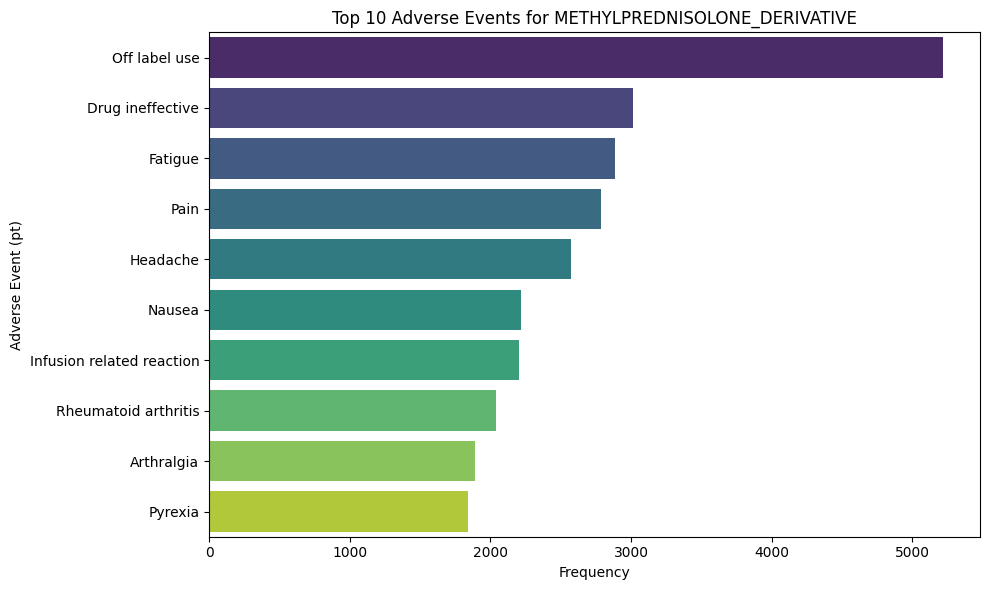

<ipython-input-7-ba7f8be5ab51>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


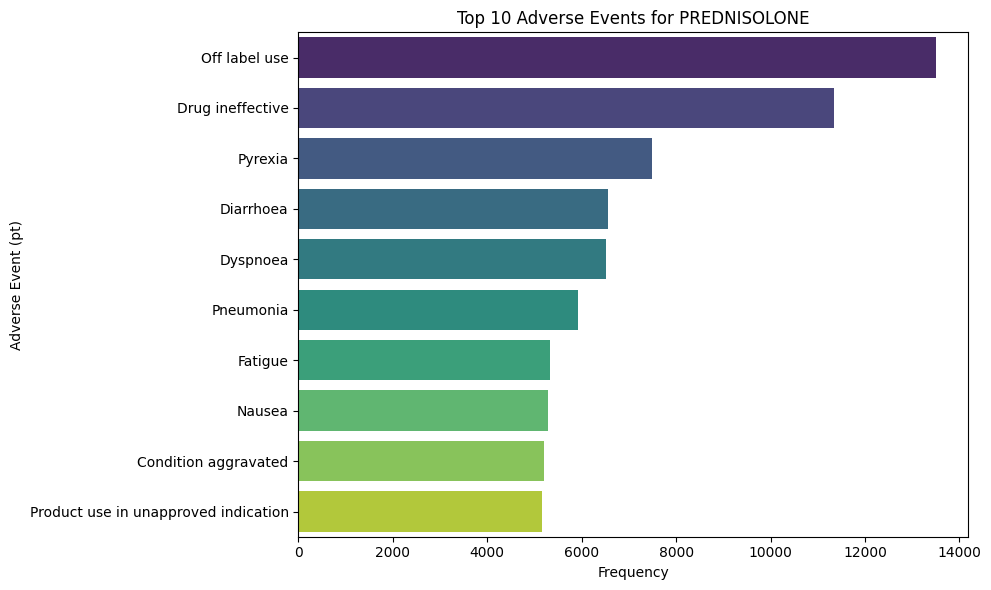

<ipython-input-7-ba7f8be5ab51>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


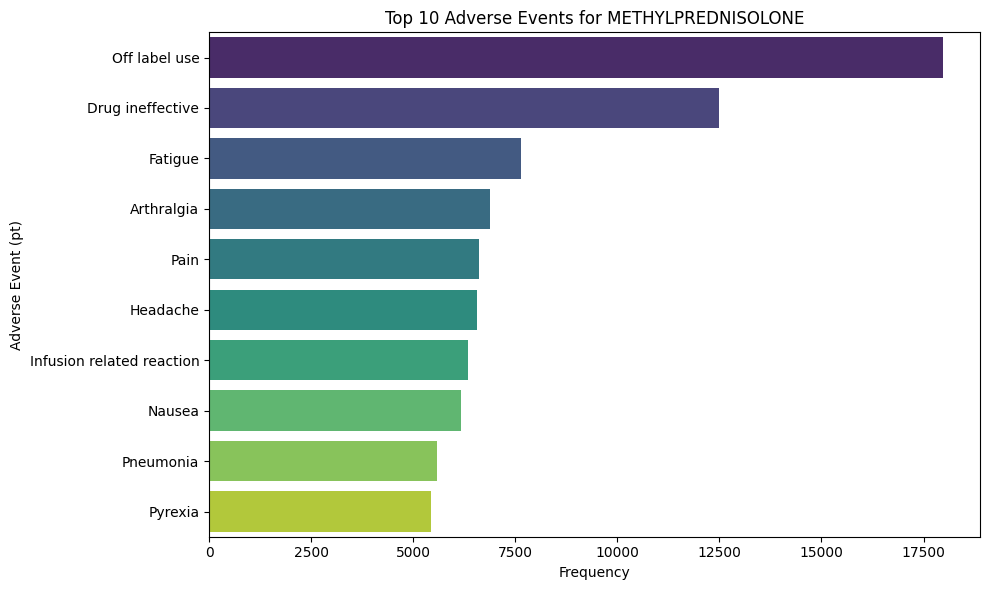

<ipython-input-7-ba7f8be5ab51>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


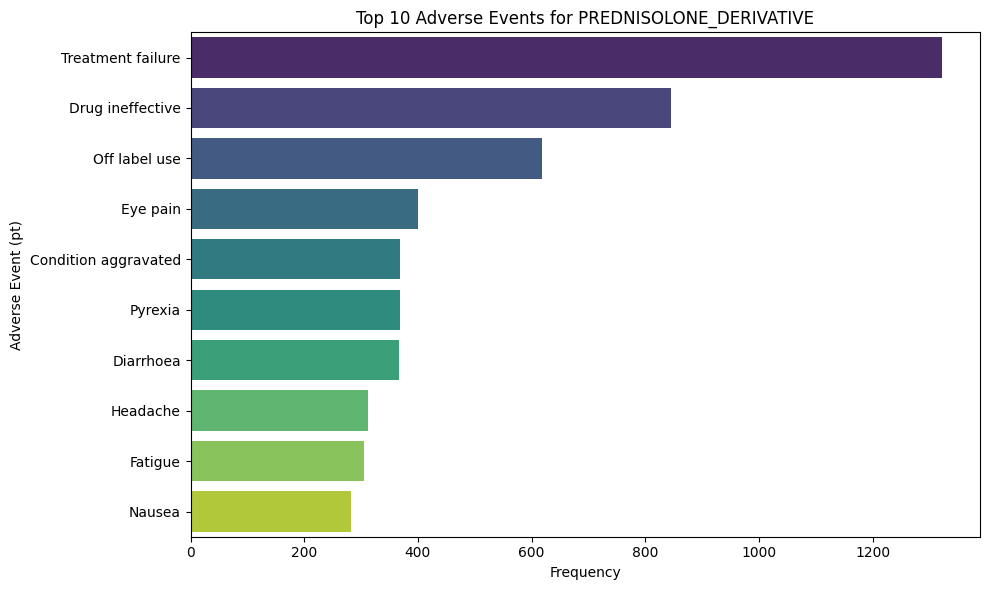

<ipython-input-7-ba7f8be5ab51>:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")


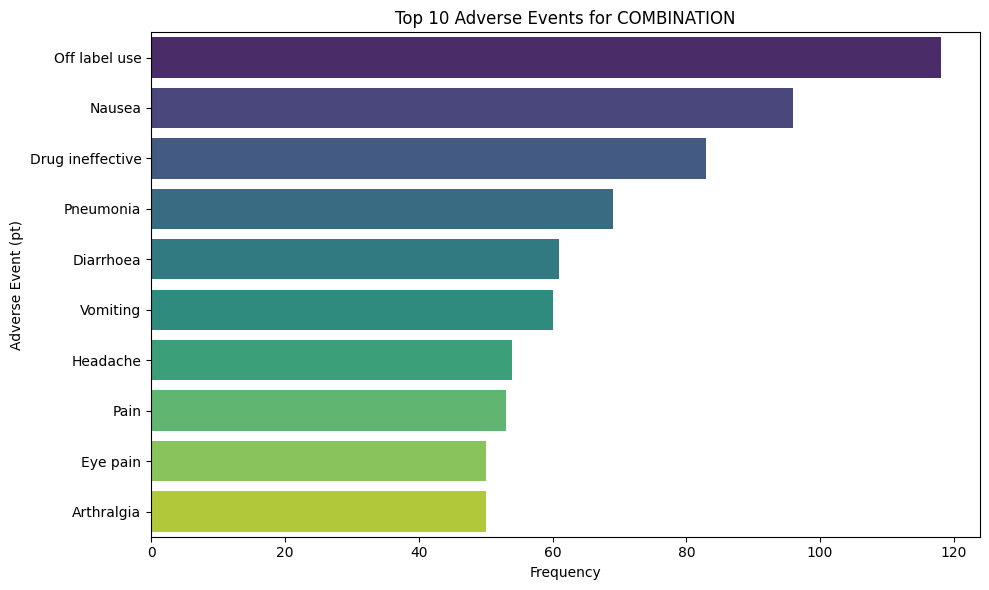

<ipython-input-7-ba7f8be5ab51>:27: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='major_class_5cat', y='age', data=final_one_row, palette="Set3")


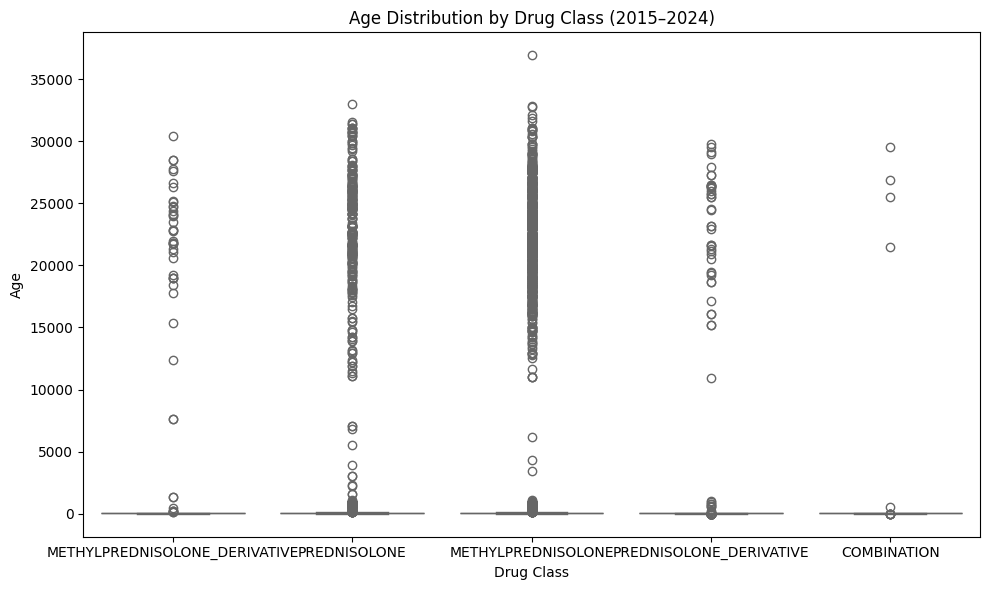

In [7]:
# Explode the aggregated 'pt' column into individual adverse events

# Create a new column 'pt_list' by splitting the 'pt' string
final_one_row['pt_list'] = final_one_row['pt'].str.split("; ")
# Explode the list so that each adverse event is in a separate row
exploded_df = final_one_row.explode('pt_list')

# Visualization: Top common adverse events by drug class
# Get the unique drug classes (drop any NaN)
drug_classes = final_one_row['major_class_5cat'].dropna().unique()

# For each drug class, compute the top 10 most common adverse events and plot a bar chart
for drug_class in drug_classes:
    df_temp = exploded_df[exploded_df['major_class_5cat'] == drug_class]
    top_events = df_temp['pt_list'].value_counts().head(10)

    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_events.values, y=top_events.index, palette="viridis")
    plt.title(f"Top 10 Adverse Events for {drug_class}")
    plt.xlabel("Frequency")
    plt.ylabel("Adverse Event (pt)")
    plt.tight_layout()
    plt.show()

# Visualization: Age distribution by drug class
plt.figure(figsize=(10, 6))
sns.boxplot(x='major_class_5cat', y='age', data=final_one_row, palette="Set3")
plt.title("Age Distribution by Drug Class (2015–2024)")
plt.xlabel("Drug Class")
plt.ylabel("Age")
plt.tight_layout()
plt.show()


Total unique adverse event terms: 11762
Cluster 0: ['Pain', 'Bone pain', 'Axillary pain', 'Chest pain', 'Oropharyngeal pain']
Cluster 1: ['Blood creatine increased', 'Beta 2 microglobulin increased', 'Respiratory rate increased', 'Weight increased', 'Blood immunoglobulin G increased']
Cluster 2: ['Abscess limb', 'Chest wall abscess', 'Abscess', 'Incision site abscess', 'Rectal abscess']
Cluster 3: ['Renal cell carcinoma', 'Basal cell carcinoma', 'Plasma cell myeloma', 'Squamous cell carcinoma', 'Lip and/or oral cavity cancer stage 0']
Cluster 4: ['Gastrointestinal disorder', 'Attention deficit/hyperactivity disorder', 'Cognitive disorder', 'Speech disorder', 'Movement disorder']
Cluster 5: ['Gastrointestinal haemorrhage', 'Mouth haemorrhage', 'Pulmonary alveolar haemorrhage', 'Wound haemorrhage', 'Procedural haemorrhage']
Cluster 6: ['Toxic skin eruption', 'Skin necrosis', 'Precancerous skin lesion', 'Skin cancer', 'Fungal skin infection']
Cluster 7: ['Blood glucose decreased', 'Decrea

<ipython-input-8-6f09cd3f383e>:64: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')


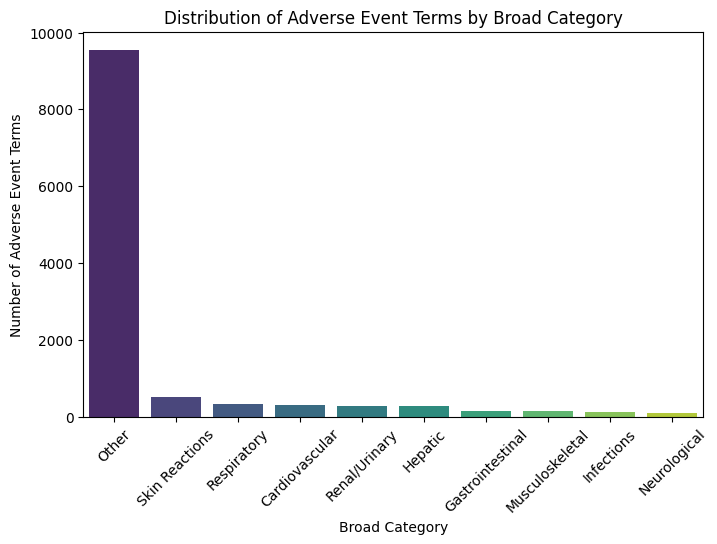

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

# Extract all unique adverse event terms from the exploded column in exploded_df.
# Assume exploded_df is already created from your aggregated data and contains a column 'pt_list',
# where each row corresponds to a single adverse event term.
unique_pt_terms = exploded_df['pt_list'].dropna().unique()
unique_pt_terms = list(unique_pt_terms)
print(f"Total unique adverse event terms: {len(unique_pt_terms)}")

# Vectorize the adverse event terms using TF-IDF.
vectorizer = TfidfVectorizer(stop_words='english')
X_pt = vectorizer.fit_transform(unique_pt_terms)

# Use K-Means clustering to group the terms into 10 clusters.
num_clusters = 10
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(X_pt)
clusters = kmeans.labels_

# Create a DataFrame mapping each adverse event term to its assigned cluster.
pt_clusters = pd.DataFrame({'pt_term': unique_pt_terms, 'cluster': clusters})

# OPTIONAL: Print the top 5 terms for each cluster for inspection.
for i in range(num_clusters):
    terms = pt_clusters[pt_clusters['cluster'] == i]['pt_term'].head(5).tolist()
    print(f"Cluster {i}: {terms}")

# Manually define a mapping from cluster id to broad category names.
# (Adjust these names based on your domain expertise.)
cluster_labels = {
    0: "Gastrointestinal",
    1: "Skin Reactions",
    2: "Neurological",
    3: "Cardiovascular",
    4: "Respiratory",
    5: "Musculoskeletal",
    6: "Infections",
    7: "Renal/Urinary",
    8: "Hepatic",
    9: "Other"
}

pt_clusters['broad_category'] = pt_clusters['cluster'].map(cluster_labels)
print("Adverse event terms with assigned clusters and broad categories:")
print(pt_clusters.sort_values('cluster').head(20))

# Merge the broad category mapping back into the main exploded DataFrame.
# We match the 'pt_list' from exploded_df with 'pt_term' in pt_clusters.
exploded_df = exploded_df.merge(pt_clusters[['pt_term', 'broad_category']],
                                left_on='pt_list', right_on='pt_term', how='left')
# Optionally, drop the redundant column 'pt_term'
exploded_df.drop(columns=['pt_term'], inplace=True)
print("Updated exploded_df with 'broad_category':")
print(exploded_df.head(10))

# Use the pt_clusters DataFrame for an overall cluster count.
# Step: Count number of pt_terms per broad category
cluster_counts = pt_clusters['broad_category'].value_counts()
# Map numeric cluster indices to broad category names using the cluster_labels dictionary
cluster_counts.index = cluster_counts.index.map(lambda x: cluster_labels.get(x, str(x)))

plt.figure(figsize=(8, 5))
sns.barplot(x=cluster_counts.index, y=cluster_counts.values, palette='viridis')
plt.xlabel("Broad Category")
plt.ylabel("Number of Adverse Event Terms")
plt.title("Distribution of Adverse Event Terms by Broad Category")
plt.xticks(rotation=45)
plt.show()



In [9]:
# Save final processed data to a CSV file on Google Drive
csv_path = "/content/drive/My Drive/final_processed_data.csv"
final_one_row.to_csv(csv_path, index=False)
print(f"Final processed data has been saved to {csv_path}")


Final processed data has been saved to /content/drive/My Drive/final_processed_data.csv


In [10]:
final_one_row

,year,quarter,caseid,age,sex,drugname_clean,major_class_5cat,pt,indi_pt,dechal,rechal,age_group,pt_list
0,2015,Q1,3759885,56.0,M,METHYLPREDNISOLONE SODIUM SUCCINATE (METHYLPRE...,METHYLPREDNISOLONE_DERIVATIVE,Chronic gastritis; Gastric polyps; Gastrointes...,Immunosuppressant drug therapy; Renal transplant,None,None,50-65,"[Chronic gastritis, Gastric polyps, Gastrointe..."
1,2015,Q1,6154259,95.0,F,PREDNISOLONE.,PREDNISOLONE,Acute kidney injury; Adrenocortical steroid th...,Herpes zoster,None,U,65+,"[Acute kidney injury, Adrenocortical steroid t..."
2,2015,Q1,6238012,62.0,M,METHYLPREDNISOLONE.,METHYLPREDNISOLONE,Blood creatine increased; Coma; Hyperuricaemia...,Hepatocellular carcinoma,None,D,50-65,"[Blood creatine increased, Coma, Hyperuricaemi..."
3,2015,Q1,6736578,44.0,F,PREDNISOLONE.,PREDNISOLONE,Hypoaesthesia; Ocular hypertension; Oral herpe...,Lupus nephritis,D,D,35-50,"[Hypoaesthesia, Ocular hypertension, Oral herp..."
4,2015,Q1,6762250,69.0,F,PREDNISOLONE.,PREDNISOLONE,Beta 2 microglobulin increased; Haemodialysis;...,Lupus nephritis; Product used for unknown indi...,D,D,65+,"[Beta 2 microglobulin increased, Haemodialysis..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
289678,2024,Q4,24795336,67.0,M,PREDNISOLONE,PREDNISOLONE,Cough; Cytomegalovirus infection reactivation;...,Product used for unknown indication,U,None,65+,"[Cough, Cytomegalovirus infection reactivation..."
289679,2024,Q4,24795452,40.0,F,METHYLPREDNISOLONE,METHYLPREDNISOLONE,Abdominal discomfort; Abdominal distension; Ab...,Migraine; Product used for unknown indication;...,U,None,35-50,"[Abdominal discomfort, Abdominal distension, A..."
289680,2024,Q4,24795481,40.0,F,METHYLPREDNISOLONE SODIUM SUCCINATE,METHYLPREDNISOLONE_DERIVATIVE,C-reactive protein abnormal; C-reactive protei...,Migraine; Product used for unknown indication;...,D,None,35-50,"[C-reactive protein abnormal, C-reactive prote..."
289681,2024,Q4,24795517,84.0,M,PREDNISOLONE,PREDNISOLONE,Off label use; Pulmonary embolism,Immune thrombocytopenia,None,None,65+,"[Off label use, Pulmonary embolism]"


In [11]:

# Reconstruct exploded_df if not already available
final_one_row['pt_list'] = final_one_row['pt'].str.split("; ")
exploded_df = final_one_row.explode('pt_list')
exploded_df = exploded_df[~exploded_df['pt_list'].isna()]


In [12]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Extract unique adverse events
unique_pt_terms = exploded_df['pt_list'].dropna().unique().tolist()

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english', min_df=1)
X_pt = vectorizer.fit_transform(unique_pt_terms)

# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pt_pca = pca.fit_transform(X_pt.toarray())

# KMeans Clustering
optimal_k = 10
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init='auto')
kmeans.fit(X_pt)
clusters = kmeans.labels_

# Create DataFrame
pt_clusters = pd.DataFrame({
    'pt_term': unique_pt_terms,
    'cluster': clusters,
    'PC1': X_pt_pca[:, 0],
    'PC2': X_pt_pca[:, 1]
})


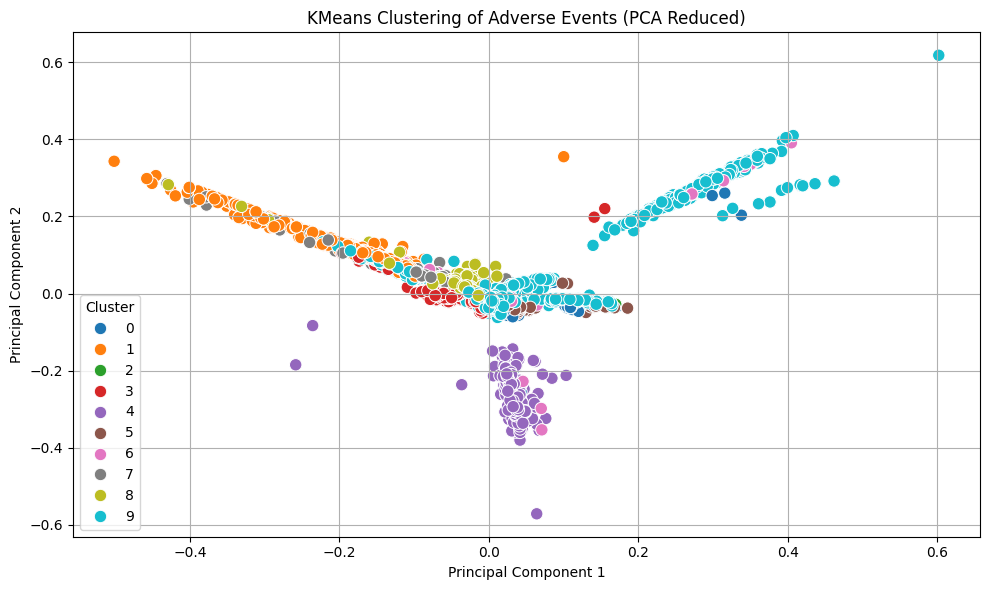

   cluster                                      example_terms
0        0  Pain, Bone pain, Axillary pain, Chest pain, Or...
1        1  Blood creatine increased, Beta 2 microglobulin...
2        2  Abscess limb, Chest wall abscess, Abscess, Inc...
3        3  Renal cell carcinoma, Basal cell carcinoma, Pl...
4        4  Gastrointestinal disorder, Attention deficit/h...
5        5  Gastrointestinal haemorrhage, Mouth haemorrhag...
6        6  Toxic skin eruption, Skin necrosis, Precancero...
7        7  Blood glucose decreased, Decreased appetite, W...
8        8  Culture urine positive, DNA antibody positive,...
9        9  Chronic gastritis, Gastric polyps, Haemangioma...


In [13]:

# Visualize Clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pt_clusters, x='PC1', y='PC2', hue='cluster', palette='tab10', s=80)
plt.title("KMeans Clustering of Adverse Events (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()

# Show examples
cluster_sample = pt_clusters.groupby('cluster')['pt_term'].apply(lambda x: ', '.join(x.head(5))).reset_index()
cluster_sample.columns = ['cluster', 'example_terms']
print(cluster_sample)


In [14]:

# Define corrected cluster labels based on observed keywords
correction_map = {
    0: "Gastrointestinal",
    1: "Skin Reactions",
    2: "Neurological",
    3: "Cardiovascular",
    4: "Respiratory",
    5: "Musculoskeletal",
    6: "Infections",
    7: "Renal/Urinary",
    8: "Hepatic",
    9: "Other"
}

# Apply correction map
pt_clusters['broad_category'] = pt_clusters['cluster'].map(correction_map)

# Merge back into exploded_df
exploded_df = exploded_df.merge(pt_clusters[['pt_term', 'broad_category']],
                                left_on='pt_list', right_on='pt_term', how='left')

# Clean up
exploded_df.drop(columns=['pt_term'], inplace=True, errors='ignore')

# Safe preview to verify success
print("Preview of classified adverse event terms:")
print(exploded_df[['pt_list', 'broad_category']].dropna().head(10))


Preview of classified adverse event terms:
                          pt_list broad_category
0               Chronic gastritis          Other
1                  Gastric polyps          Other
2       Gastrointestinal disorder    Respiratory
3                     Haemangioma          Other
4   Human herpesvirus 8 infection          Other
5                Kaposi's sarcoma          Other
6     Kidney transplant rejection          Other
7        Pneumatosis intestinalis          Other
8             Acute kidney injury          Other
9  Adrenocortical steroid therapy          Other


In [15]:

# Define black/red line terms
black_terms = ['drug ineffective']
red_terms = ['fatigue', 'pain']

# Generate date column
quarter_to_month = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}
exploded_df['quarter_end'] = exploded_df['quarter'].map(quarter_to_month)
exploded_df['report_date'] = pd.to_datetime(exploded_df['year'].astype(str) + '-' + exploded_df['quarter_end'])

# Event Group 1
exploded_df['event_group'] = exploded_df['pt_list'].apply(
    lambda x: 'Drug Ineffective' if x in black_terms else ('Clinical Symptoms' if x in red_terms else None)
)


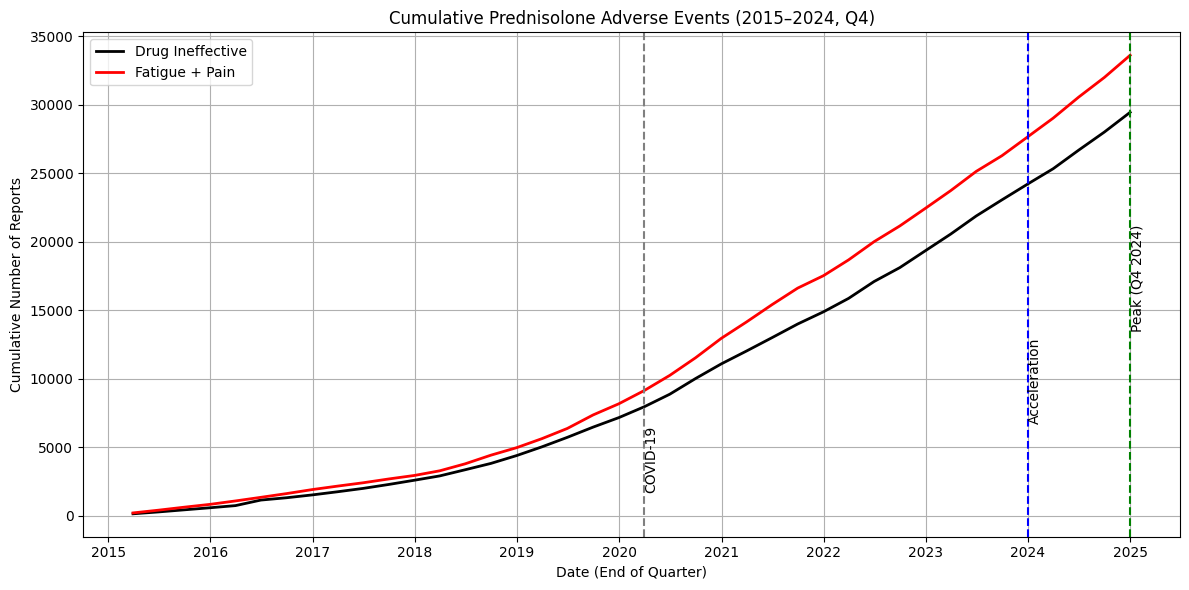

In [19]:
# Ensure pt_list is clean and lowercased
exploded_df = exploded_df.copy()
exploded_df = exploded_df[~exploded_df['pt_list'].isna()]
exploded_df['pt_list_lower'] = exploded_df['pt_list'].str.lower()

# Rebuild report_date
quarter_to_month = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}
exploded_df['report_date'] = pd.to_datetime(
    exploded_df['year'].astype(str) + '-' + exploded_df['quarter'].map(quarter_to_month))

# Define categories
black_terms = ['drug ineffective']
red_terms = ['fatigue', 'pain']

exploded_df['event_group'] = exploded_df['pt_list_lower'].apply(
    lambda x: 'Drug Ineffective' if x in black_terms else ('Clinical Symptoms' if x in red_terms else None)
)

# Filter + group + pivot
filtered_df = exploded_df[exploded_df['event_group'].notna()]
grouped = filtered_df.groupby(['report_date', 'event_group']).size().reset_index(name='count')
pivoted = grouped.pivot(index='report_date', columns='event_group', values='count').fillna(0)
pivoted_cumsum = pivoted.cumsum()


plt.figure(figsize=(12, 6))

# Draw lines only if data exists
if 'Drug Ineffective' in pivoted_cumsum.columns:
    plt.plot(pivoted_cumsum.index, pivoted_cumsum['Drug Ineffective'], label='Drug Ineffective', color='black', linewidth=2)

if 'Clinical Symptoms' in pivoted_cumsum.columns:
    plt.plot(pivoted_cumsum.index, pivoted_cumsum['Clinical Symptoms'], label='Fatigue + Pain', color='red', linewidth=2)

# Add reference markers
plt.axvline(pd.to_datetime('2020-03-31'), linestyle='--', color='gray')
plt.text(pd.to_datetime('2020-03-31'), pivoted_cumsum.max().max()*0.05, 'COVID-19', rotation=90, verticalalignment='bottom')

plt.axvline(pd.to_datetime('2023-12-31'), linestyle='--', color='blue')
plt.text(pd.to_datetime('2023-12-31'), pivoted_cumsum.max().max()*0.2, 'Acceleration', rotation=90, verticalalignment='bottom')

plt.axvline(pd.to_datetime('2024-12-31'), linestyle='--', color='green')
plt.text(pd.to_datetime('2024-12-31'), pivoted_cumsum.max().max()*0.4, 'Peak (Q4 2024)', rotation=90, verticalalignment='bottom')

# Finalize plot
plt.title("Cumulative Prednisolone Adverse Events (2015–2024, Q4)")
plt.xlabel("Date (End of Quarter)")
plt.ylabel("Cumulative Number of Reports")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

cluster
0    11762
Name: count, dtype: int64


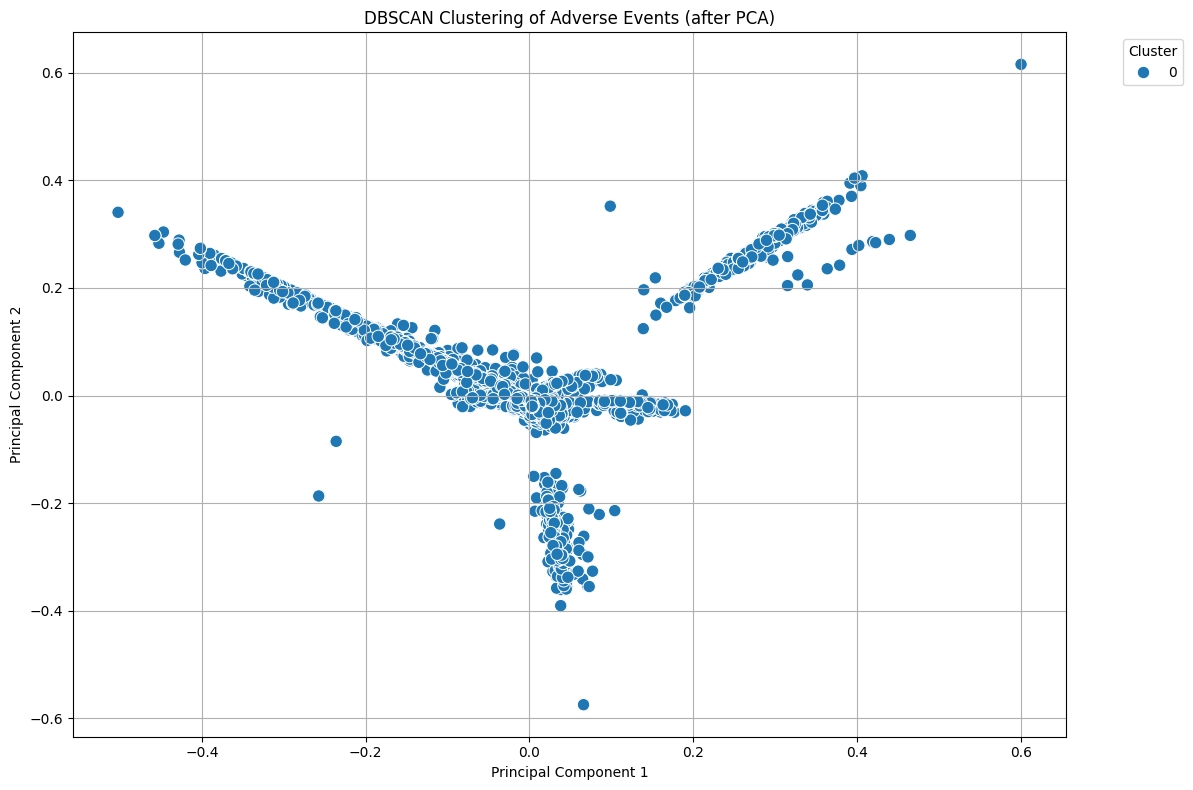

   cluster                                      example_terms
0        0  Chronic gastritis, Gastric polyps, Gastrointes...


In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN

# Prepare unique adverse event terms
unique_pt_terms = exploded_df['pt_list'].dropna().unique().tolist()

# Vectorize adverse events text features using TF-IDF
vectorizer = TfidfVectorizer(stop_words='english')
X_pt = vectorizer.fit_transform(unique_pt_terms)

# Use PCA to reduce the high-dimensional TF-IDF vector to 2 dimensions for subsequent visualization
pca = PCA(n_components=2, random_state=42)
X_pt_pca = pca.fit_transform(X_pt.toarray())

# Apply DBSCAN for clustering
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pt_pca)

# Constructing clustering result DataFrame
pt_clusters_dbscan = pd.DataFrame({
    'pt_term': unique_pt_terms,
    'cluster': dbscan_labels,
    'PC1': X_pt_pca[:, 0],
    'PC2': X_pt_pca[:, 1]
})

# Display the number of samples in each cluster
print(pt_clusters_dbscan['cluster'].value_counts())

# Visualizing Results: DBSCAN Clustering
plt.figure(figsize=(12, 8))
palette = sns.color_palette('tab20', np.unique(dbscan_labels).size)
sns.scatterplot(
    data=pt_clusters_dbscan, x='PC1', y='PC2',
    hue='cluster', palette=palette,
    style=(pt_clusters_dbscan['cluster'] == -1),
    markers={True: "X", False: "o"}, s=80
)
plt.title("DBSCAN Clustering of Adverse Events (after PCA)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# View the representative adverse event of each cluster
cluster_sample = pt_clusters_dbscan.groupby('cluster')['pt_term'].apply(lambda x: ', '.join(x.head(5))).reset_index()
cluster_sample.columns = ['cluster', 'example_terms']
print(cluster_sample)

In [21]:
# Summarize by cluster, and take the top 10 common adverse events of each cluster as reference
cluster_summary = pt_clusters_dbscan.groupby('cluster')['pt_term'].apply(lambda x: ', '.join(x.head(10))).reset_index()
cluster_summary.columns = ['cluster', 'example_terms']

print("Each Cluster Example Terms (for manual mapping):")
print(cluster_summary)


Each Cluster Example Terms (for manual mapping):
   cluster                                      example_terms
0        0  Chronic gastritis, Gastric polyps, Gastrointes...


In [22]:
cluster_summary

,cluster,example_terms
0,0,"Chronic gastritis, Gastric polyps, Gastrointes..."


In [23]:
!pip install hdbscan

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN cluster summary:
cluster
-1      4414
 455    1059
 217      87
 148      84
 225      84
        ... 
 391       5
 324       5
 335       5
 165       5
 228       5
Name: count, Length: 465, dtype: int64


<ipython-input-24-decad02edfdd>:49: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


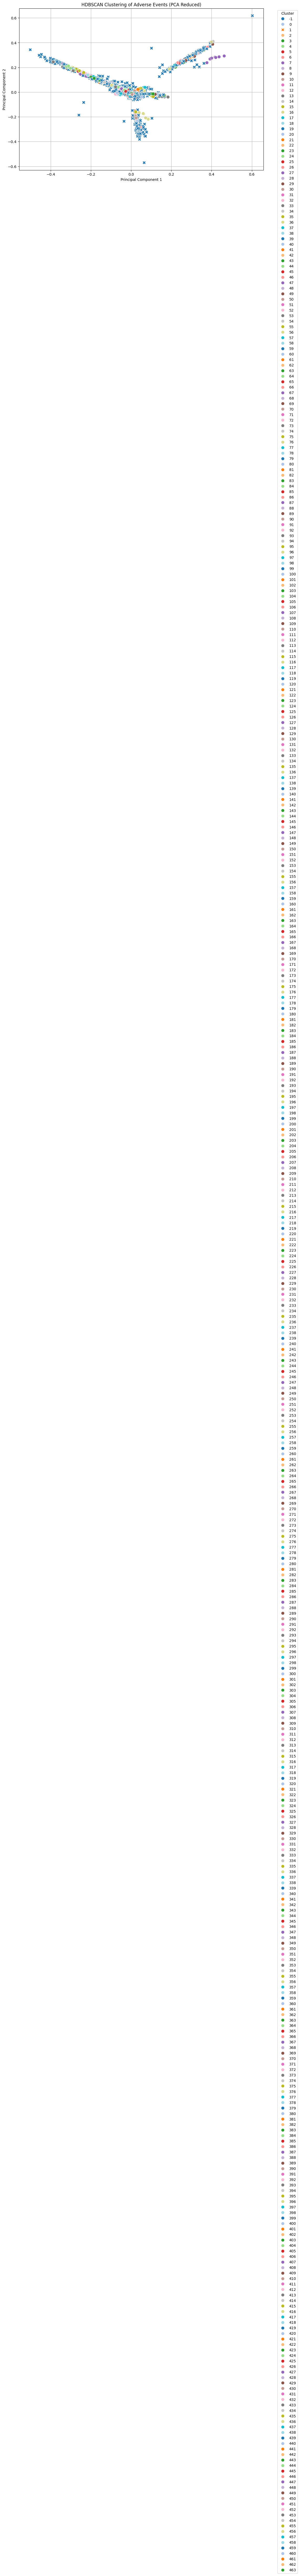

     cluster                                      example_terms
0         -1  Gastrointestinal disorder, Haemangioma, Pneuma...
1          0  Gastrointestinal haemorrhage, Upper gastrointe...
2          1  Skin ulcer, Infected skin ulcer, Amoebic skin ...
3          2  Incision site abscess, Injection site abscess,...
4          3  Infusion site ulcer, Application site ulcer, S...
..       ...                                                ...
460      459  Dystonia, Cheilitis, Hemianopia, Lentigo, Tris...
461      460  Proteinuria, American trypanosomiasis, Elephan...
462      461  Aphasia, CNS ventriculitis, In vitro fertilisa...
463      462  Hyperaesthesia, Crime, Oophoritis, Osteoarthro...
464      463  Myalgia, Amyotrophy, Myoclonus, Hysterectomy, ...

[465 rows x 2 columns]


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import hdbscan

# Prepare unique adverse event terms
unique_pt_terms = exploded_df['pt_list'].dropna().unique().tolist()

# TF-IDF Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_pt = vectorizer.fit_transform(unique_pt_terms)

# PCA reduction to 50D for clustering
pca_for_clustering = PCA(n_components=50, random_state=42)
X_pt_reduced = pca_for_clustering.fit_transform(X_pt.toarray())

# HDBSCAN clustering on 50D reduced vectors
hdb = hdbscan.HDBSCAN(min_cluster_size=5, min_samples=3, metric='euclidean')
hdb_labels = hdb.fit_predict(X_pt_reduced)

# Separate PCA to 2D only for visualization
pca_for_plot = PCA(n_components=2, random_state=42)
X_pt_pca = pca_for_plot.fit_transform(X_pt_reduced)

# Build clustering result DataFrame
pt_clusters_hdbscan = pd.DataFrame({
    'pt_term': unique_pt_terms,
    'cluster': hdb_labels,
    'PC1': X_pt_pca[:, 0],
    'PC2': X_pt_pca[:, 1]
})

print("HDBSCAN cluster summary:")
print(pt_clusters_hdbscan['cluster'].value_counts())

# Visualize HDBSCAN clustering result after PCA
plt.figure(figsize=(12, 8))
palette = sns.color_palette('tab20', np.unique(hdb_labels).size)
sns.scatterplot(
    data=pt_clusters_hdbscan, x='PC1', y='PC2',
    hue='cluster', palette=palette,
    style=(pt_clusters_hdbscan['cluster'] == -1),
    markers={True: "X", False: "o"}, s=80
)
plt.title("HDBSCAN Clustering of Adverse Events (PCA Reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

# Display example adverse events for each cluster
cluster_sample = pt_clusters_hdbscan.groupby('cluster')['pt_term'].apply(lambda x: ', '.join(x.head(5))).reset_index()
cluster_sample.columns = ['cluster', 'example_terms']
print(cluster_sample)

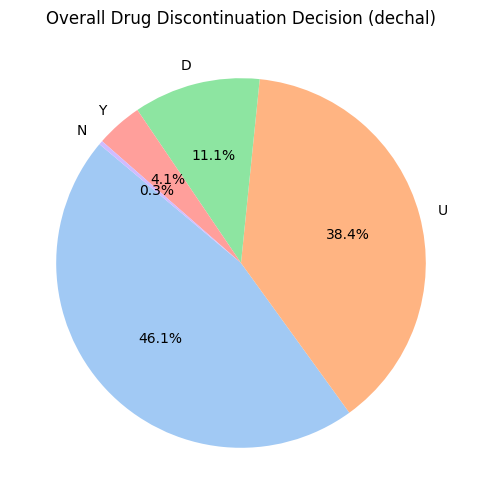

In [25]:
dechal_counts = exploded_df['dechal'].value_counts(dropna=False)
plt.figure(figsize=(6,6))
plt.pie(dechal_counts, labels=dechal_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title("Overall Drug Discontinuation Decision (dechal)")
plt.show()

In [26]:
print(prednisolone_df['dechal'].value_counts(dropna=False))

dechal
NaN    192753
U      143630
D       54632
Y       27469
N        2466
Name: count, dtype: int64


<ipython-input-27-1a2597325bd1>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dechal_rate_per_category.values, y=dechal_rate_per_category.index, palette="viridis")


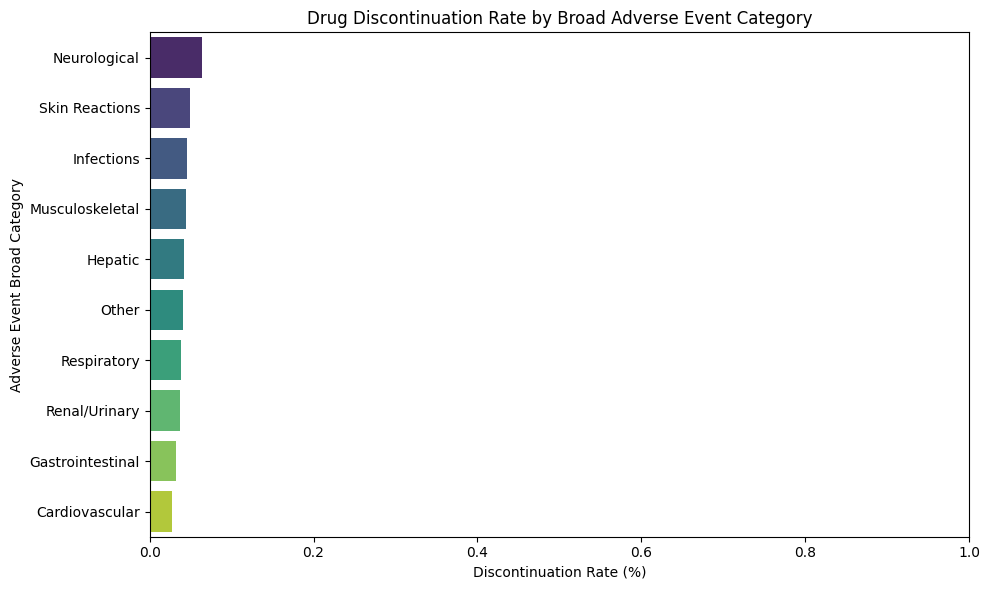

In [27]:
# Calculate dechal='Yes' rate for each broad category
dechal_rate_per_category = exploded_df.groupby('broad_category')['dechal'].apply(lambda x: (x == 'Y').mean()).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=dechal_rate_per_category.values, y=dechal_rate_per_category.index, palette="viridis")
plt.title("Drug Discontinuation Rate by Broad Adverse Event Category")
plt.xlabel("Discontinuation Rate (%)")
plt.ylabel("Adverse Event Broad Category")
plt.xlim(0, 1)
plt.tight_layout()
plt.show()

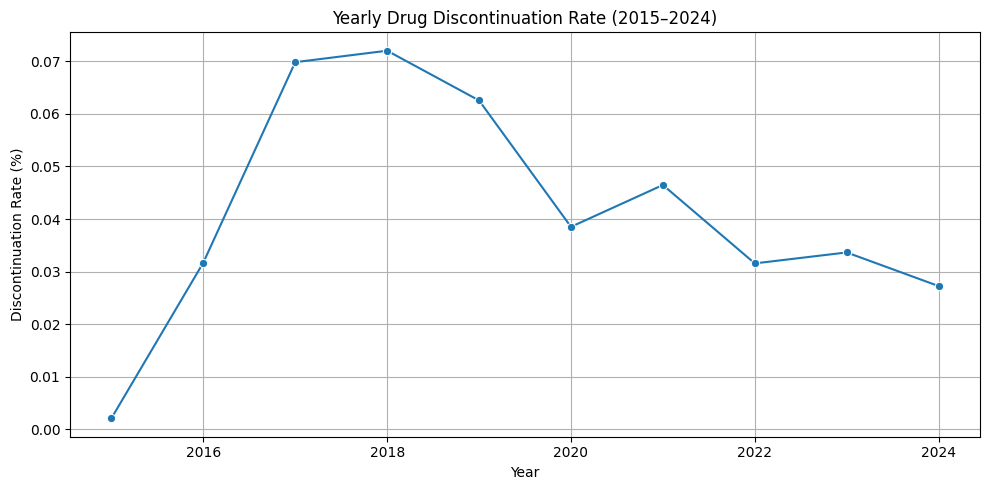

In [28]:
# First generate report_date if not exist
if 'report_date' not in exploded_df.columns:
    quarter_to_month = {'Q1': '03-31', 'Q2': '06-30', 'Q3': '09-30', 'Q4': '12-31'}
    exploded_df['report_date'] = pd.to_datetime(exploded_df['year'].astype(str) + '-' + exploded_df['quarter'].map(quarter_to_month))

# Calculate discontinuation rate by year
yearly_dechal_rate = exploded_df.groupby(exploded_df['year'])['dechal'].apply(lambda x: (x == 'Y').mean()).reset_index(name='discontinuation_rate')

plt.figure(figsize=(10,5))
sns.lineplot(x='year', y='discontinuation_rate', data=yearly_dechal_rate, marker="o")
plt.title("Yearly Drug Discontinuation Rate (2015–2024)")
plt.xlabel("Year")
plt.ylabel("Discontinuation Rate (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

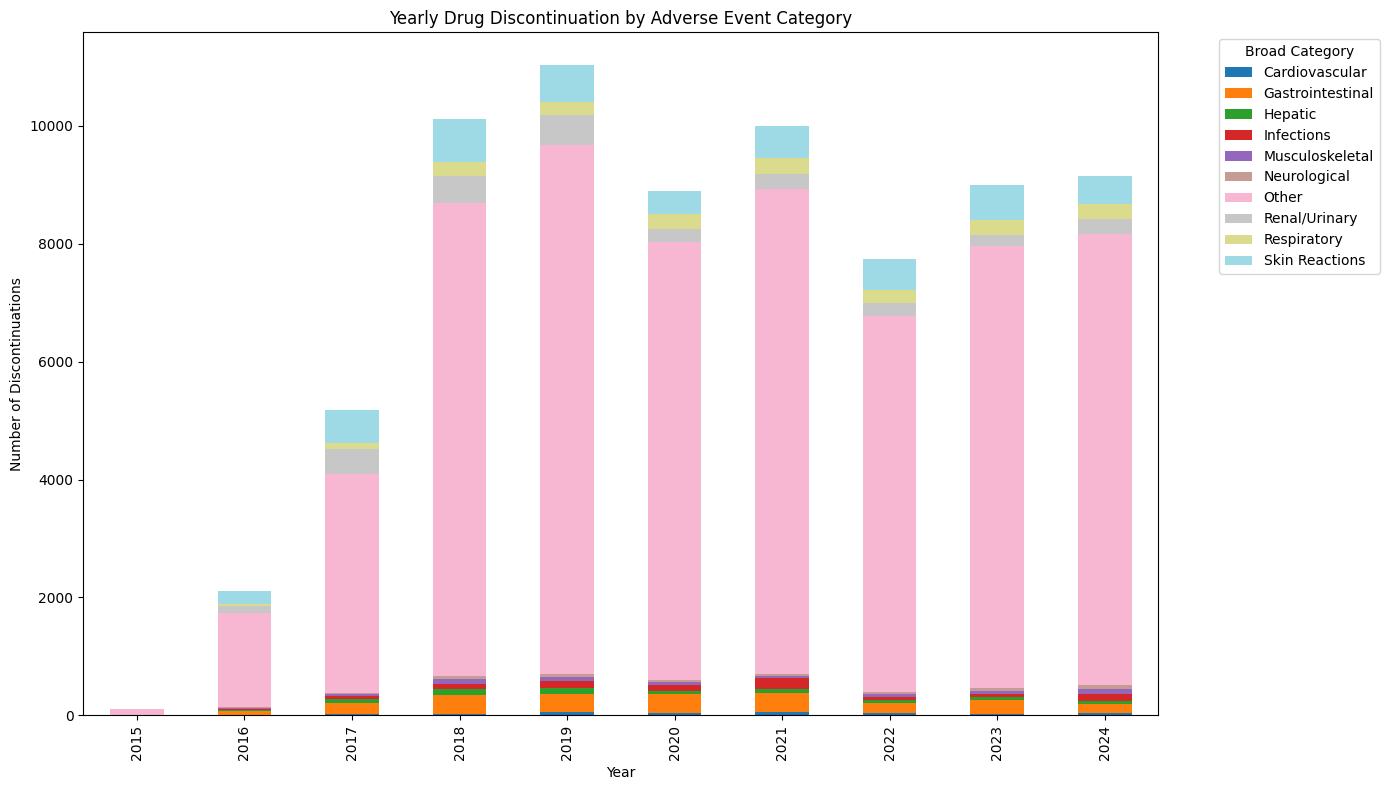

In [29]:
# Filter only rows where dechal == 'Yes'
dechal_yes = exploded_df[exploded_df['dechal'] == 'Y']

pivot = dechal_yes.groupby(['year', 'broad_category']).size().reset_index(name='count')
pivot_table = pivot.pivot(index='year', columns='broad_category', values='count').fillna(0)

pivot_table.plot(kind='bar', stacked=True, figsize=(14,8), colormap='tab20')
plt.title("Yearly Drug Discontinuation by Adverse Event Category")
plt.xlabel("Year")
plt.ylabel("Number of Discontinuations")
plt.legend(title="Broad Category", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

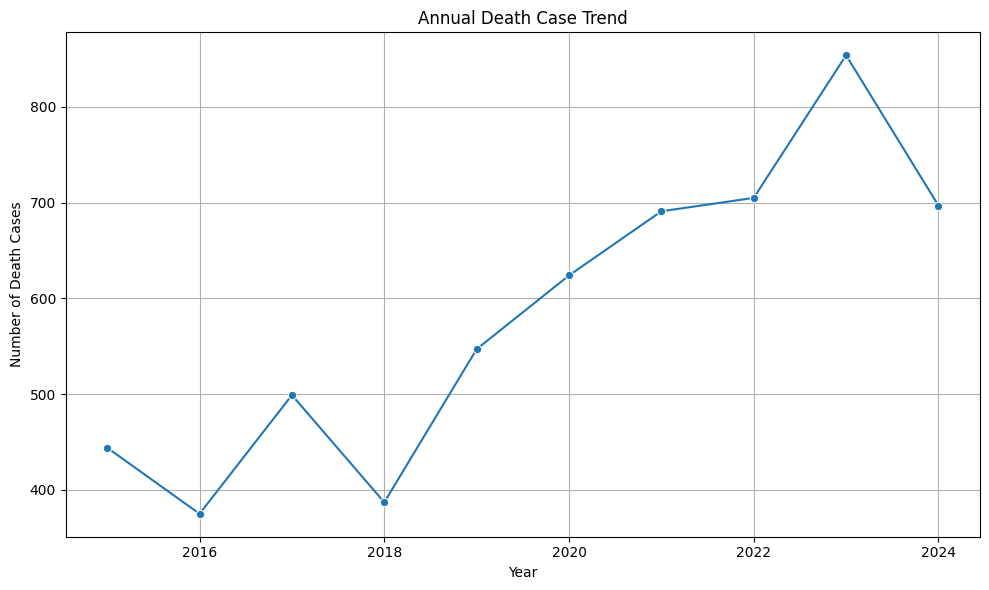

In [30]:
# Filter for death cases
death_cases = exploded_df[exploded_df['pt_list'].str.lower() == 'death']

# Count deaths per year
annual_deaths = death_cases.groupby('year').size().reset_index(name='death_count')

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(data=annual_deaths, x='year', y='death_count', marker='o')
plt.title('Annual Death Case Trend')
plt.xlabel('Year')
plt.ylabel('Number of Death Cases')
plt.grid(True)
plt.tight_layout()
plt.show()

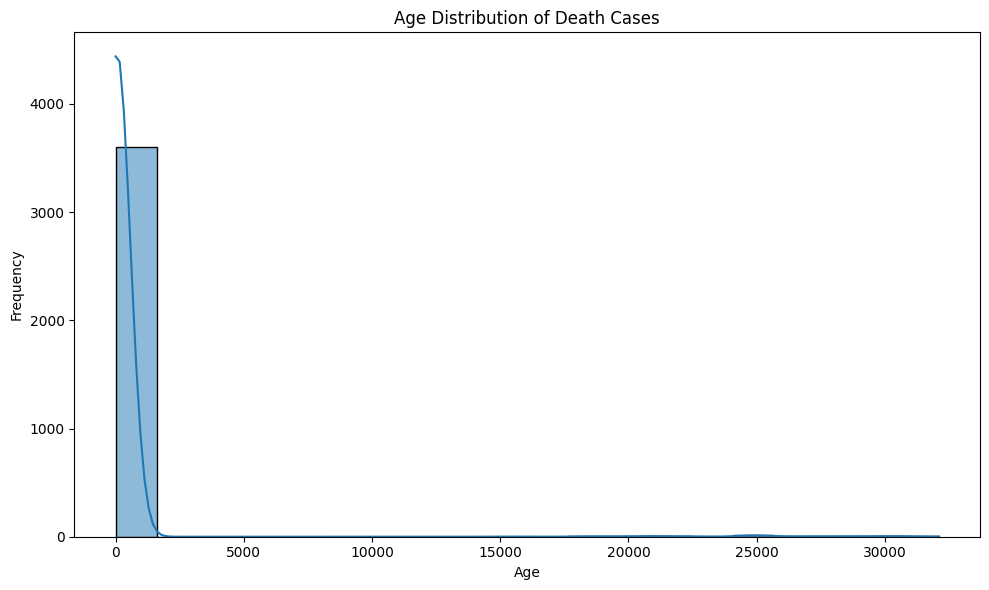

In [31]:
# Plot
plt.figure(figsize=(10, 6))
sns.histplot(death_cases['age'].dropna(), bins=20, kde=True)
plt.title('Age Distribution of Death Cases')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

count     3645.000000
mean       344.548422
std       2656.483693
min          0.000000
25%         52.000000
50%         66.000000
75%         76.000000
max      32101.000000
Name: age, dtype: float64
Max age: 32101.0
Ages > 120:
            age
37233   26778.0
62158   30773.0
76212   24912.0
108718  22724.0
189934  21150.0


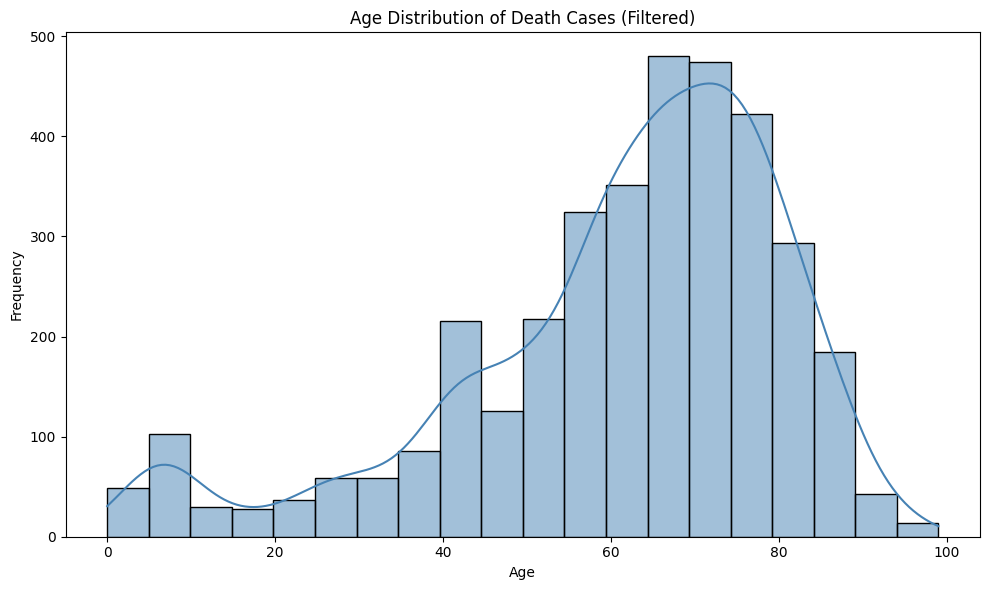

In [32]:
print(death_cases['age'].describe())
print("Max age:", death_cases['age'].max())
print("Ages > 120:")
print(death_cases[death_cases['age'] > 120][['age']].head())
filtered = death_cases[(death_cases['age'] >= 0) & (death_cases['age'] <= 120)]
plt.figure(figsize=(10, 6))
sns.histplot(filtered['age'].dropna(), bins=20, kde=True, color="steelblue")
plt.title('Age Distribution of Death Cases (Filtered)')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

<ipython-input-34-d3285547e7f5>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_deaths, x='Gender', y='Death Count', palette='pastel')


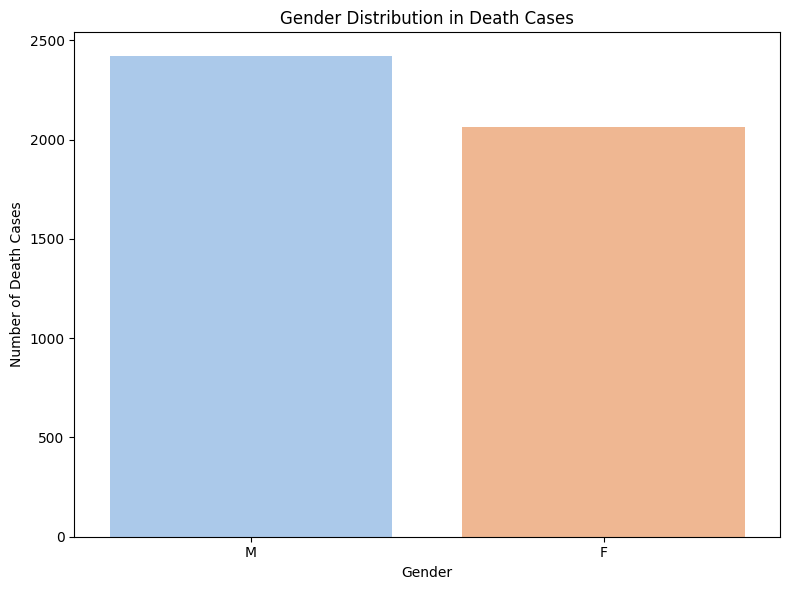

In [34]:
# Count deaths by gender
gender_deaths = death_cases['sex'].value_counts().reset_index()
gender_deaths.columns = ['Gender', 'Death Count']

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(data=gender_deaths, x='Gender', y='Death Count', palette='pastel')
plt.title('Gender Distribution in Death Cases')
plt.xlabel('Gender')
plt.ylabel('Number of Death Cases')
plt.tight_layout()
plt.show()

<ipython-input-35-aa3587695d1d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=drug_class_deaths, x='Drug Class', y='Death Count', palette='muted')


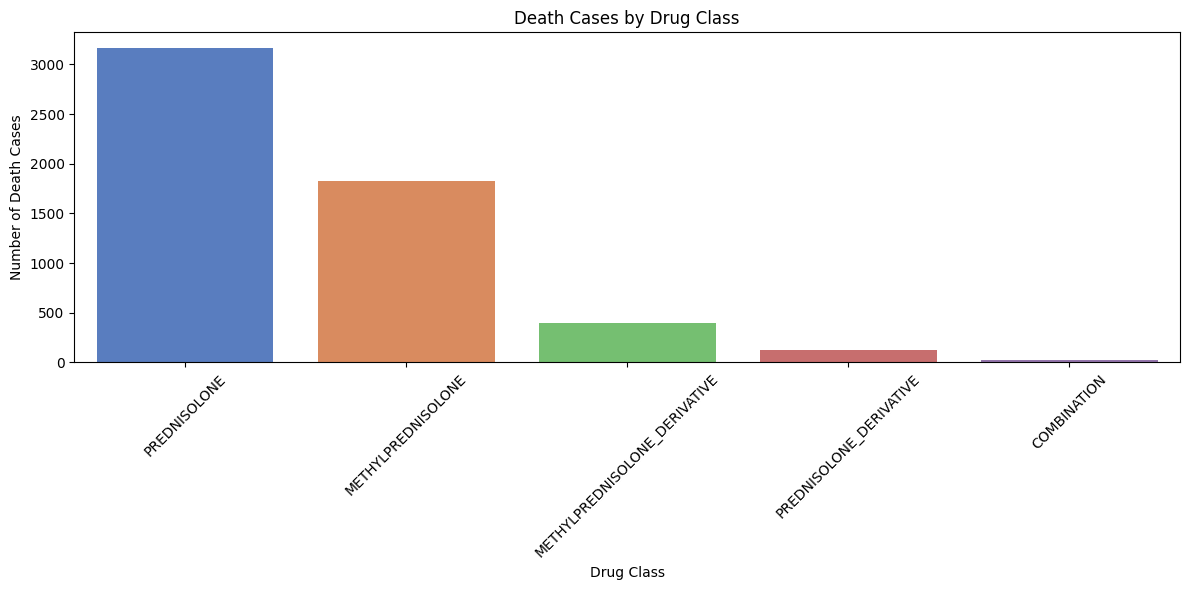

In [35]:
# Count deaths by drug class
drug_class_deaths = death_cases['major_class_5cat'].value_counts().reset_index()
drug_class_deaths.columns = ['Drug Class', 'Death Count']

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=drug_class_deaths, x='Drug Class', y='Death Count', palette='muted')
plt.title('Death Cases by Drug Class')
plt.xlabel('Drug Class')
plt.ylabel('Number of Death Cases')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

<ipython-input-36-1e3dd9cc98af>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_rate_by_class.values, y=death_rate_by_class.index, palette="Reds_r")


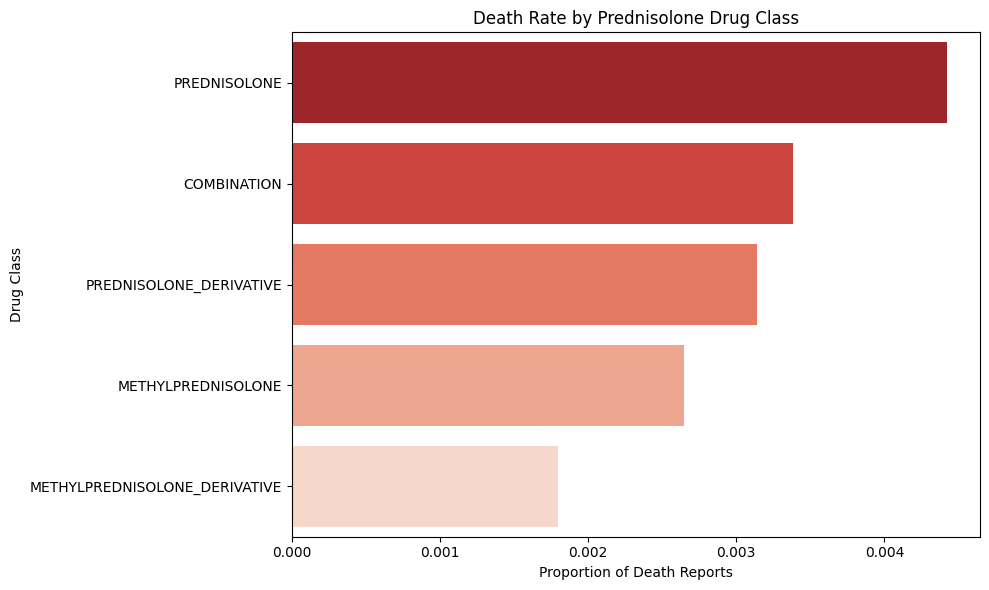

In [36]:
# Normalize pt field
exploded_df['pt_list_lower'] = exploded_df['pt_list'].str.lower()

# Create death flag
exploded_df['is_death'] = exploded_df['pt_list_lower'] == 'death'

# Death rate by drug class
death_rate_by_class = exploded_df.groupby('major_class_5cat')['is_death'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=death_rate_by_class.values, y=death_rate_by_class.index, palette="Reds_r")
plt.title("Death Rate by Prednisolone Drug Class")
plt.xlabel("Proportion of Death Reports")
plt.ylabel("Drug Class")
plt.tight_layout()
plt.show()

<ipython-input-37-6d814a48b881>:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_death_counts = death_age_group.groupby('age_group').size()
<ipython-input-37-6d814a48b881>:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_total_counts = exploded_df[exploded_df['age_group'].notna()].groupby('age_group').size()
<ipython-input-37-6d814a48b881>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=age_death_rate.index, y=age_death_rate.values, palette='magma')


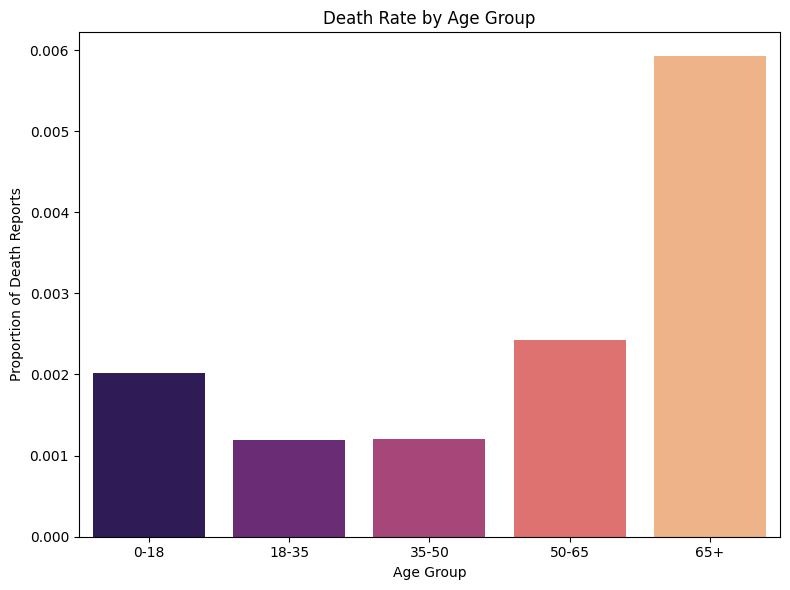

In [37]:
# Drop invalid ages
death_age_group = exploded_df[exploded_df['is_death'] & exploded_df['age_group'].notna()]
age_death_counts = death_age_group.groupby('age_group').size()
age_total_counts = exploded_df[exploded_df['age_group'].notna()].groupby('age_group').size()
age_death_rate = (age_death_counts / age_total_counts).sort_index()

plt.figure(figsize=(8,6))
sns.barplot(x=age_death_rate.index, y=age_death_rate.values, palette='magma')
plt.title("Death Rate by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Proportion of Death Reports")
plt.tight_layout()
plt.show()

<ipython-input-38-89f0f8c27ab2>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=death_rate_by_category.values, y=death_rate_by_category.index, palette="flare")


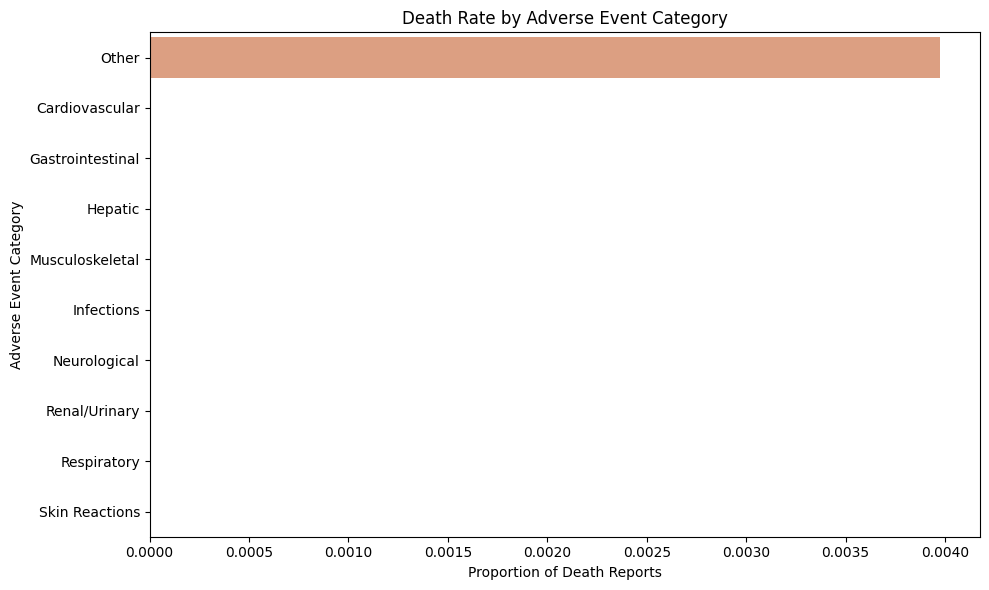

In [38]:
death_rate_by_category = exploded_df.groupby('broad_category')['is_death'].mean().sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=death_rate_by_category.values, y=death_rate_by_category.index, palette="flare")
plt.title("Death Rate by Adverse Event Category")
plt.xlabel("Proportion of Death Reports")
plt.ylabel("Adverse Event Category")
plt.tight_layout()
plt.show()

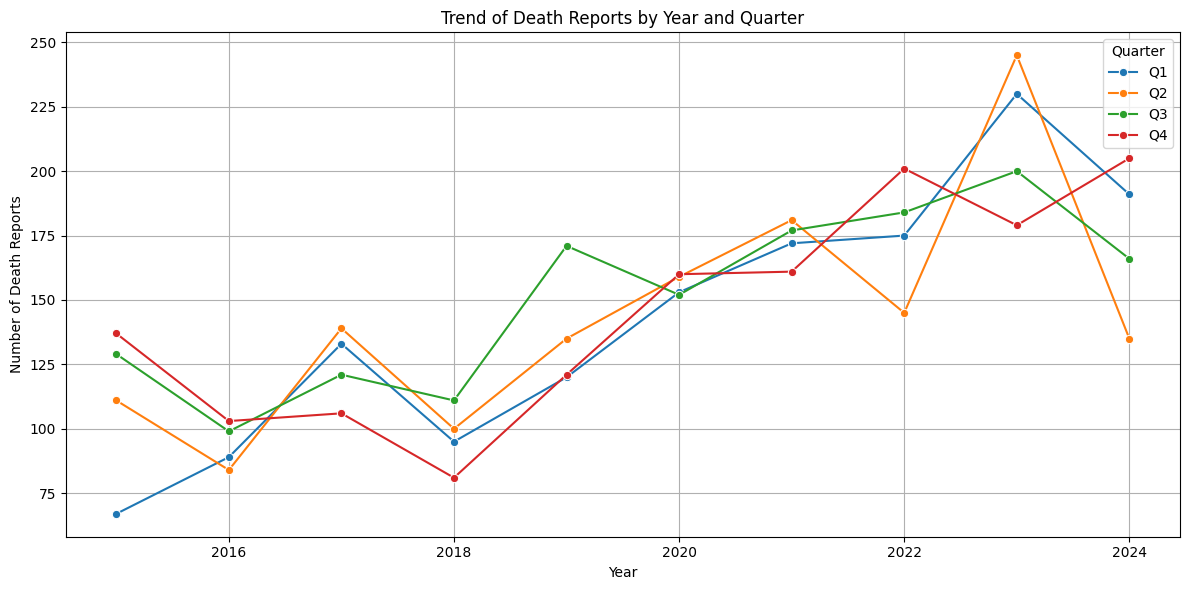

In [39]:
# Aggregate death reports over time
death_trend = exploded_df[exploded_df['is_death']].groupby(['year', 'quarter']).size().reset_index(name='death_count')

plt.figure(figsize=(12,6))
sns.lineplot(x='year', y='death_count', hue='quarter', data=death_trend, marker='o')
plt.title("Trend of Death Reports by Year and Quarter")
plt.xlabel("Year")
plt.ylabel("Number of Death Reports")
plt.legend(title="Quarter")
plt.grid(True)
plt.tight_layout()
plt.show()

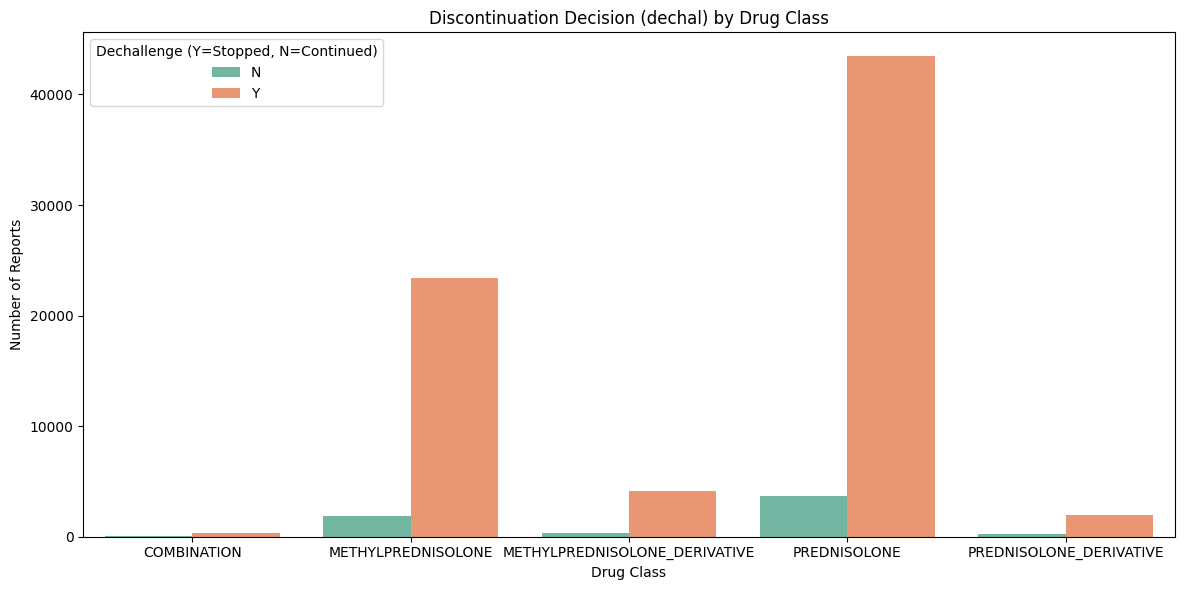

In [40]:
# Normalize dechal
exploded_df['dechal'] = exploded_df['dechal'].str.upper()
dechal_counts = exploded_df[exploded_df['dechal'].isin(['Y', 'N'])].groupby(['major_class_5cat', 'dechal']).size().reset_index(name='count')

plt.figure(figsize=(12,6))
sns.barplot(x='major_class_5cat', y='count', hue='dechal', data=dechal_counts, palette="Set2")
plt.title("Discontinuation Decision (dechal) by Drug Class")
plt.xlabel("Drug Class")
plt.ylabel("Number of Reports")
plt.legend(title="Dechallenge (Y=Stopped, N=Continued)")
plt.tight_layout()
plt.show()

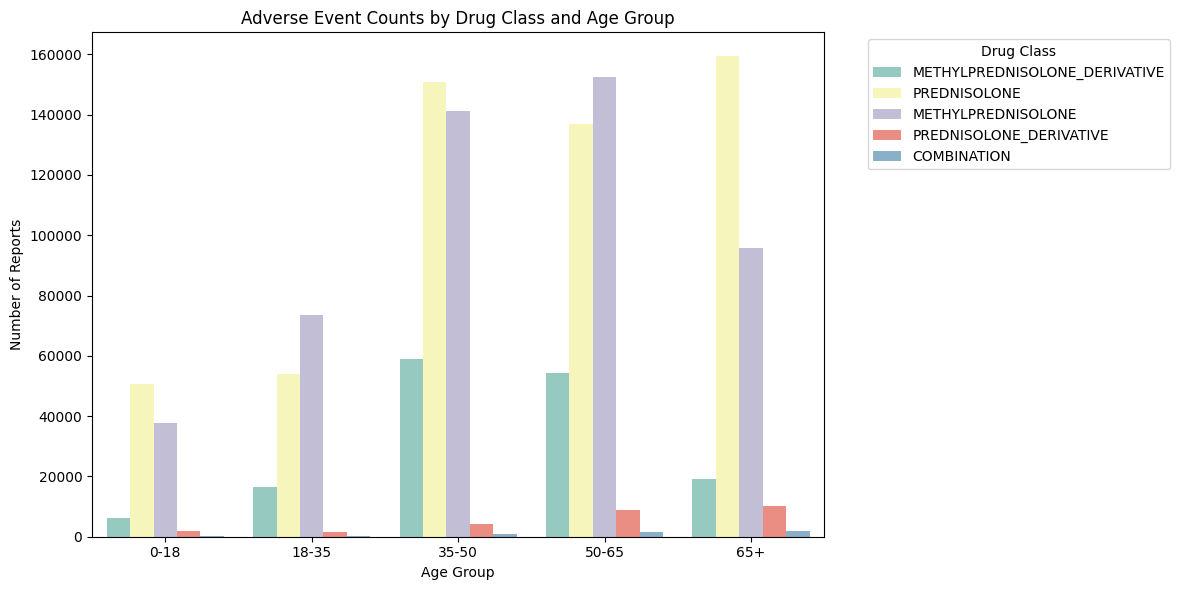

In [41]:
plt.figure(figsize=(12,6))
sns.countplot(data=exploded_df, x='age_group', hue='major_class_5cat', palette='Set3')
plt.title("Adverse Event Counts by Drug Class and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Number of Reports")
plt.legend(title="Drug Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

<ipython-input-42-ee92cf89a0ee>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_pt.index, x=top_pt.values, palette='Blues_d')


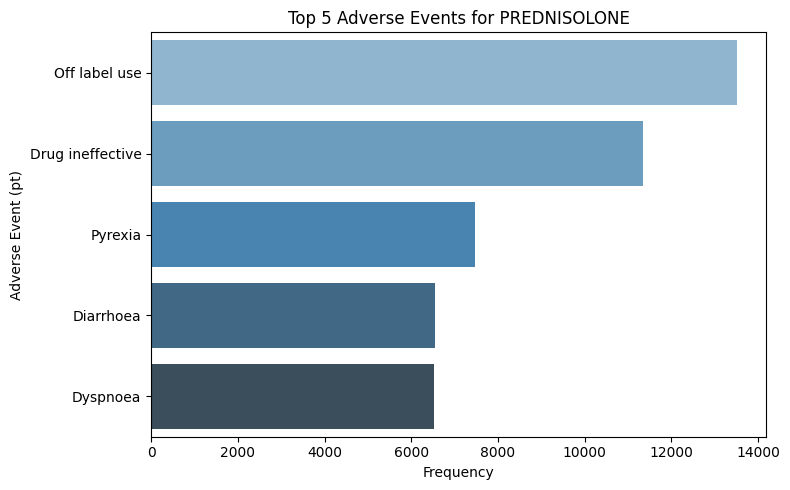

<ipython-input-42-ee92cf89a0ee>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_pt.index, x=top_pt.values, palette='Blues_d')


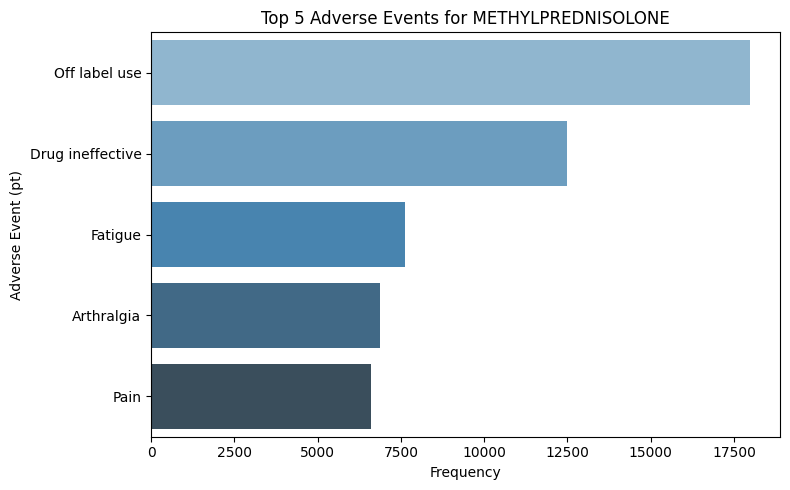

<ipython-input-42-ee92cf89a0ee>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_pt.index, x=top_pt.values, palette='Blues_d')


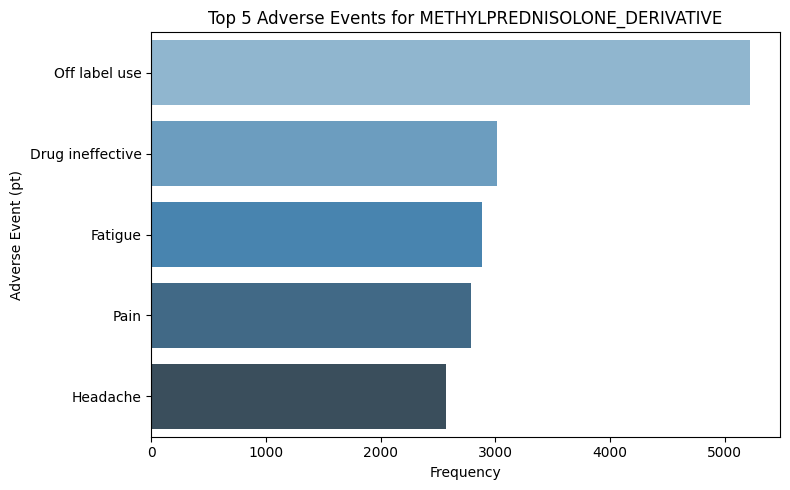

In [42]:
top_classes = exploded_df['major_class_5cat'].value_counts().index[:3]

for cls in top_classes:
    top_pt = exploded_df[exploded_df['major_class_5cat'] == cls]['pt_list'].value_counts().head(5)
    plt.figure(figsize=(8,5))
    sns.barplot(y=top_pt.index, x=top_pt.values, palette='Blues_d')
    plt.title(f"Top 5 Adverse Events for {cls}")
    plt.xlabel("Frequency")
    plt.ylabel("Adverse Event (pt)")
    plt.tight_layout()
    plt.show()

<ipython-input-43-f84c6006dd04>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=dose_reduced_rate.values, y=dose_reduced_rate.index, palette='PuBuGn')


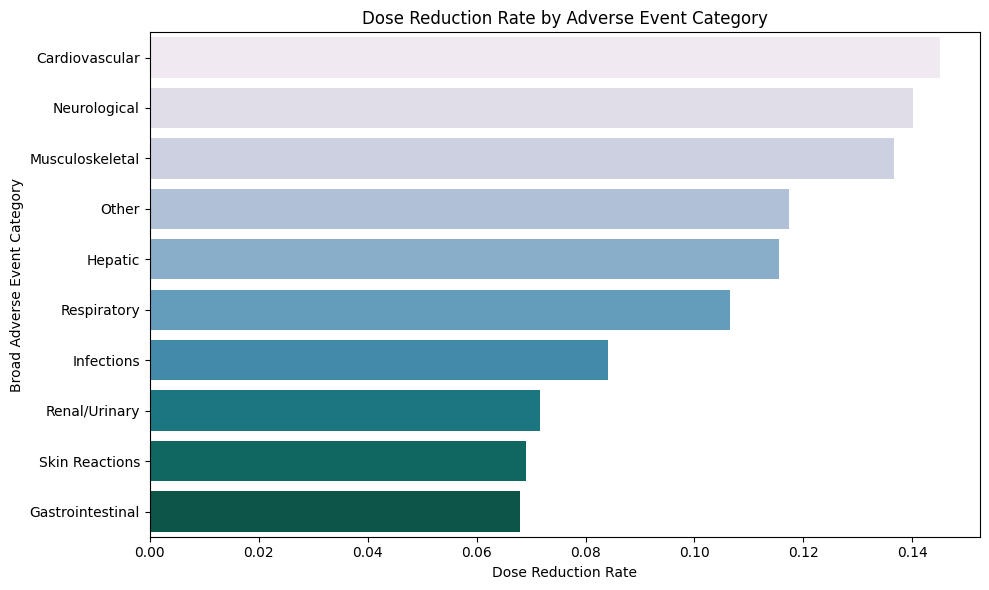

In [43]:
dose_reduced_rate = exploded_df.groupby('broad_category')['dechal'].apply(lambda x: (x == 'D').mean()).sort_values(ascending=False)

plt.figure(figsize=(10,6))
sns.barplot(x=dose_reduced_rate.values, y=dose_reduced_rate.index, palette='PuBuGn')
plt.title("Dose Reduction Rate by Adverse Event Category")
plt.xlabel("Dose Reduction Rate")
plt.ylabel("Broad Adverse Event Category")
plt.tight_layout()
plt.show()

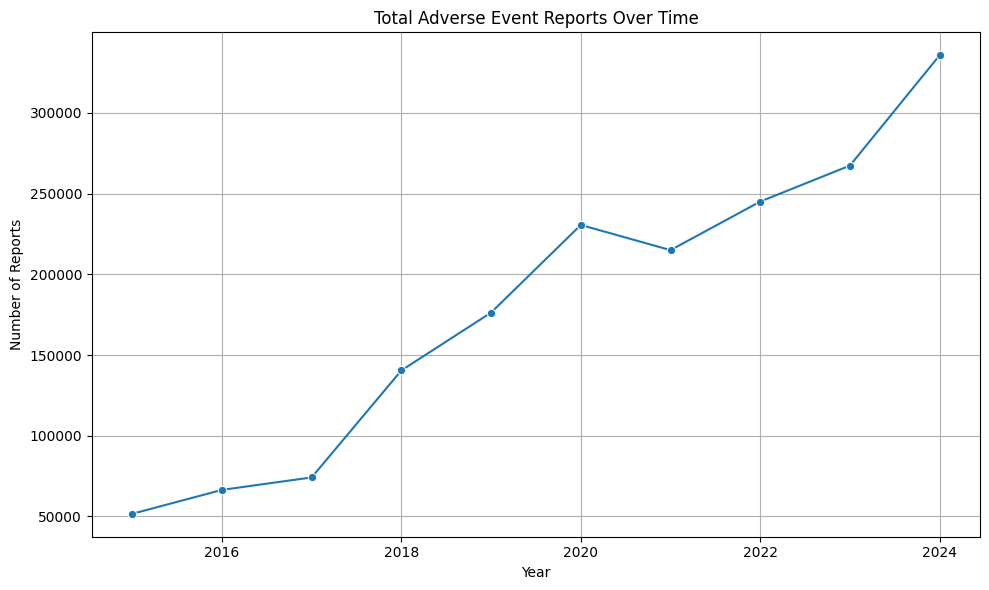

In [44]:
total_event_trend = exploded_df.groupby('year').size().reset_index(name='event_count')

plt.figure(figsize=(10,6))
sns.lineplot(data=total_event_trend, x='year', y='event_count', marker='o')
plt.title("Total Adverse Event Reports Over Time")
plt.xlabel("Year")
plt.ylabel("Number of Reports")
plt.grid(True)
plt.tight_layout()
plt.show()